> In statistics, **multicollinearity** (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others. - From <a href="https://en.wikipedia.org/wiki/Multicollinearity" target="_blank">Wikipedia</a>

Data scientists love linear regression due to its high model interpretability. Unlike other complex machine learning models (ex: K-nearest neighbor, random forest, or neural net), the interpretation of model parameters is straightforward. Assume a linear regression model defined by  <span style="font-size: 90% !important">$y = 110 x_1 + 50 x_2$</span>. Then, increasing <span style="font-size: 90% !important">$x_1$</span> by 2 will increase <span style="font-size: 90% !important">$y$</span> by 220, and increasing <span style="font-size: 90% !important">$x_2$</span> by 3 will increase y by 150, controlling the other variable constant. However, it turns out that you can't really <i>"control"<i> the other variable under multicollinearity.

Sometimes the values or signs (+/-) of linear regression coefficients have special meanings. This is the case when a linear regression model is based on a physics model. For illustration, I show <a href="#eq-1">eq (1)</a>, the material balance equation (MBE) used in petroleum engineering to calculate the amount of oil and gas trapped in a geologic hydrocarbon reservoir (source: Eq 14. from this <a href="https://petrowiki.org/Material_balance_in_oil_reservoirs" target="_blank">petrowiki page</a>). 

<div id="eq-1" style="font-size: 1rem;">
$$ F = G_{fgi}x_{1} + N_{foi}x_{2} + W_e \tag{1}$$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-3">$F$</div>
        <div class="col-9">: <i>"Dependent Variable"</i> total net fluid withdrawal or production</div>
    </div>
    <div class="row">
        <div class="col-3">$x_{1}$</div>
        <div class="col-9">: <i>"Independent Variable"</i> composite gas expansivity</div>
    </div>
    <div class="row">
        <div class="col-3">$x_{2}$</div>
        <div class="col-9">: <i>"Independent Variable"</i> composite oil expansivity</div>
    </div>  
    <div class="row">
        <div class="col-3">$G_{fgi}$</div>
        <div class="col-9">: <i>"Regression Coefficient"</i> initial free gas</div>
    </div>
    <div class="row">
        <div class="col-3">$N_{foi}$</div>
        <div class="col-9">: <i>"Regression Coefficient"</i> initial free oil</div>
    </div>
    <div class="row">
        <div class="col-3">$W_{e}$</div>
        <div class="col-9">: <i>"Intercept"</i> cumulative water influx</div>
    </div>
</div>

The individual value of the regression coefficients in <a href="#eq-1">eq (1)</a> is important, because oil <span style="font-size: 90% !important">$N_{foi}$</span> is more expensive than gas <span style="font-size: 90% !important">$G_{fgi}$</span> in the market. Oil & gas companies make decisions about where to drill the next well based on economic projections made from the values of <span style="font-size: 90% !important">$N_{foi}$</span> and <span style="font-size: 90% !important">$G_{fgi}$</span>. However, sometimes the values of <span style="font-size: 90% !important">$N_{foi}$</span> and <span style="font-size: 90% !important">$G_{fgi}$</span> solved with a multiple linear regression model are unreliable due to multicollinearity. I numerically demonstrate this effect in <i>Section 3.1: Model instability with sampling</i> <a href="#Model instability with sampling">below</a>.

This post attempts to help your understanding of multicollinearity and introduce solutions in Python. All sections come with Python code snippets. 

<div id="toc_container">
    <p class="toc_title">Contents</p>
    <ul class="toc_list">
        <li><a href="#Sample data description"><span class="toc_label">0</span>Sample data description</a></li>
        <li><a href="#Key takeaways"><span class="toc_label">1</span>Key takeaways</a></li>
        <li><a href="#Concept"><span class="toc_label">2</span>Concept</a></li>
        <li><a href="#Effects"><span class="toc_label">3</span>Effects</a></li>
        <ul>
            <li><a href="#Model instability with sampling"><span class="toc_label">3.1</span>Model instability with sampling</a></li>
            <li><a href="#Overestimated standard errors"><span class="toc_label">3.2</span>Overestimated standard errors</a></li>
            <li><a href="#Model instability with feature selection"><span class="toc_label">3.3</span>Model instability with feature selection</a></li>
        </ul>
        <li><a href="#Detection"><span class="toc_label">4</span>Detection</a></li>
        <ul>
            <li><a href="#VIF"><span class="toc_label">4.1</span>VIF</a></li>
            <ul>
                <li><a href="#Calculation of VIF assumes a certain structure of a model"><span class="toc_label">Notes:</span>Calculation of VIF assumes a certain structure of a model</a></li>
                <li><a href="#Three ways to compute VIF in Python"><span class="toc_label">Pythonic Tip:</span>Three ways to compute VIF in Python</a></li>
            </ul>
            <li><a href="#Correlation matrix"><span class="toc_label">4.2</span>Correlation matrix</a></li>
        </ul>
        <li><a href="#Remedies"><span class="toc_label">5</span>Remedies</a></li>
        <ul>
            <li><a href="#Removal"><span class="toc_label">5.1</span>Elimination</a></li>
            <li><a href="#Principle component regression"><span class="toc_label">5.2</span>Principle component regression</a></li>
            <li><a href="#Mean centering"><span class="toc_label">5.3</span>Mean centering</a></li>
            <li><a href="#Mean centering"><span class="toc_label">5.4</span>Increase sample size</a></li>
        </ul>
        <li><a href="#Excuses for ignoring multicollinearity"><span class="toc_label">6</span>Pitfalls</a></li>
    </ul>
</div>

Width of confidence interval and sample size

Warning! Be careful not to eliminate features just based on VIF score. Use feature ranking knowledge

Notes: Variations of correlation matrix.

Wrong data encoding - dummy variable
            <li><a href="#Calculation of VIF assumes a certain structure of a model."><span class="toc_label">Notes:</span>Calculation of VIF assumes a certain structure of a model.</a></li>

Calculation of VIF assumes a certain structure of a model.

<div id="Sample data description"></div>

## 0. Sample data description

We will generate synthetic linear data sets throughout this post. Note that I chose not to use real-life data, because it is difficult to demonstrate the instability of regression coefficients under multicollinearity; we do not know the <i>true</i> values of regression coefficients. With synthetic data, however, we can control the true values of regression coefficients and the degree of collinearity with <a href="#algorithm-1">Algorithm 1</a>. 

Assume that we want to generate collinear data with three features described by the linear model:  <span style="font-size: 90% !important">$y = 2 x_1 + 4 x_2 + 10 x_3 + 2$</span>. We can set the true values of regression coefficients with <code>true_coefs</code> and <code>true_intercept</code>:

In [1]:
true_coefs = [2, 4, 10]               # true values of the regression coefficients
true_intercept = 2                    # true vale of the intercept

<div style="margin-top: -20px"></div>

We can also control the degree of collinearity. If we want high collinearity, fill the diagonal elemens with <code>1</code>, and fill the non-diagonal elements of the positive semi-definite covariance matrix <code>cov</code> with values close to <code>1</code>:

In [23]:
correlation = 0.95                    # HIGH COLLINEARITY
cov = np.full((len(true_coefs), len(true_coefs)), correlation)
np.fill_diagonal(cov, 1)

In [24]:
cov

array([[1.  , 0.95, 0.95],
       [0.95, 1.  , 0.95],
       [0.95, 0.95, 1.  ]])

<div style="margin-top: -20px"></div>

If low collinearity is desired, fill the non-diagonal elements of <code>cov</code> with values close to 0:

In [25]:
correlation = 0.01                    # LOW COLLINEARITY
cov = np.full((len(true_coefs), len(true_coefs)), correlation)
np.fill_diagonal(cov, 1)

In [26]:
cov

array([[1.  , 0.01, 0.01],
       [0.01, 1.  , 0.01],
       [0.01, 0.01, 1.  ]])

<div style="margin-top: -20px"></div>

We generate collinear independent variables (features) with <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html" target="_blank">np.random.multivariate_normal</a>. The function takes <code>cov</code> as one of the argument, which makes it easy to generate collinear features. The below code snippet simulates <code>n = 100</code> observations of highly collinear data points, sampled from the population described by the linear model <span style="font-size: 90% !important">$y = 2 x_1 + 4 x_2 + 10 x_3 + 2$</span> with Gaussian noise.

<p id="algorithm-1"><u>Algorithm 1: Random generation of highly collinear data</u></p>

In [2]:
import numpy as np

# settings 
n = 100                               # sample size
true_coefs = [2, 4, 10]               # linear regression coefficients, 3 features
true_intercept = 2                    # y-intercept
feature_means = [5, 1, 12]            # means of gaussian features. This is not important
correlation = 0.01                    # degree of collinearity (LOW)

# positive semi-definite covariance matrix. 
cov = np.full((len(true_coefs), len(true_coefs)), correlation)
np.fill_diagonal(cov, 1)

# random generation of 3D gaussian collinear features. 100 x 3 numpy array
X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

# generate gaussian white noise. mean = 0, standard deviation = 2. 100 x 1 numpy array
gaussian_noise = np.random.normal(loc=0, scale=2, size=n)

# make the outcome. 100 x 1 numpy array
y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise

<div id="Key takeaways"></div>

## 1. Key takeaways

<div class="highlights" id="key1">
    <div class="highlights-title">1. Confidence interval quantifies uncertainty of statistical estimation</div>
    <div class="highlights-content">Confidence interval qunatifies the uncertainty related to a statistical estimation to mitigate the issue of <a href="#population_vs_samples">Population vs. Samples</a>. It is always expressed in a range like — $\text{C.I.}: \quad \bar{x} \pm 3.43$ or $-51.4 < \bar{x} < -43.2$</div>
</div>

<div class="highlights" id="key2">
    <div class="highlights-title">2. Confidence interval is the basis of parametric hypothesis tests</div>
    <div class="highlights-content">Confidence interval is the basis of parametric hypothesis tests. For example, <a href="https://www.investopedia.com/terms/t/t-test.asp" target="_blank">t-test</a> computes its p-value using the <a href="#conf_int_of_diff_in_mean">confidence interval of difference in mean</a>. When samples follow a normal distribution, and therefore their centeral tendency can be described by their means, t-test can be used to conclude if two distributions are significantly different from each other. 
    </div>
</div>

<div id="Concept"></div>

## 2. Concept

<a href="https://en.wikipedia.org/wiki/Multicollinearity" target="_blank">Wikipedia</a> has a good & concise definition of collinearity and multicollinearity. 

**Collinearity** is a linear association between two explanatory variables. Two variables are perfectly collinear if there is an exact linear relationship between them. For example, <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span> are perfectly collinear if there exist parameters <span style="font-size: 90% !important">$\lambda_0$</span> and <span style="font-size: 90% !important">$\lambda_1$</span> such that, for all observations <span style="font-size: 90% !important">$i$</span>, we have:

<div id="eq-2" style="font-size: 1rem;">
$$ X_{2i} = \lambda_0 + \lambda_1 X_{1i} \tag{2}$$
</div>

**Multicollinearity** refers to a situation in which two or more explanatory variables in a multiple regression model are linearly related. A feature does not have to be directly linearly related to a response variable, if it affects an another feature that is linearly related to the response variable. For example in <a href="#fig-1">figure (1-C)</a>, we see that although <span style="font-size: 90% !important">$X_2$</span> is not related to <span style="font-size: 90% !important">$Y$</span>, <span style="font-size: 90% !important">$X_2$</span> is related to <span style="font-size: 90% !important">$X_1$</span>, which in turn affects <span style="font-size: 90% !important">$Y$</span>.

<a href="eq-2">Eq (2)</a> shows the case of perfect collinearity, in which the correlation between <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span> is equal to 1 or -1. In practice, we rarely face perfect multicollinearity in a data set. More commonly, the issue of multicollinearity arises when there is an approximate linear relationship among two or more independent variables. For example in <a href="#fig-1">figure (1-B)</a>, we see that most of the variability of the Venn diagram can be explained by just <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$Y$</span>, and that we don't really need <span style="font-size: 90% !important">$X_2$</span>, due to the high degree of multicollinearity between <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span>, represented by the area of overlap (yellow color).

<div id="fig-1" class="row give-margin-inline-big-plot mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_venn_diagram.png"></div>
    <div class="col-12"><p class="image-description">Figure 1: Multicollinearity Venn diagram. Yellow regions represent the degree of multicollinearity between the independent variables <span style="font-size: 90% !important">$X_1$</span> and <span style="font-size: 90% !important">$X_2$</span></p></div>
</div>

<div><hr></div>

Let's try to understand multicollinearity in greater detail with thought experiments. Consider the following two scenarios.

**Scenario 1**

As a microbiologist, you want to fix the number of bacteria A growing in a petri dish to be <span style="font-size: 90% !important">$Y = 10,000$</span>. The number of bacteria A is a function of temperature and the amount of toxic chemical, described by the following linear model:

<div id="eq-3" style="font-size: 1rem;">
$$ Y = \beta_1 \cdot \text{temperature} - \beta_2 \cdot \text{toxic chemical} + \beta_0 \tag{3}$$
</div>

Based on this linear model, you can make an informed decision about how to manipulate the features (temperature and the amount of toxic chemicals) to control the number of bacteria in the petri dish. 

With <a href="eq-3">eq (3)</a>, you have full control of the number of bacteria, because the impact of each features is understood by their respective regression coefficients (<span style="font-size: 90% !important">$\beta_1$</span> for temperature, and <span style="font-size: 90% !important">$\beta_2$</span> for toxic chemicals), and the features are independent (no multicollinearity). In the other words, temperature does not affect the amount of toxic chemicals, and vice versa.

**Scenario 2**

Now, let’s assume a scenario in which the features are not independent from each other. You are growing bacteria A and bacteria B together in the same petri dish, and want to fix the number of bacteria A to be <span style="font-size: 90% !important">$Y = 10,000$</span>. The following information is known:

<ol class="rounded-list" style="margin-bottom: 40px !important; margin-top: 40px! important;">
    <li><p>Bacteria B preys on bacteria A.</p></li>
    <li><p>Temperature increases the number of the both bacteria groups.</p></li>
    <li><p>Each bacteria group emits different amount of methane. Methane traps heat, and increases temperature.</p></li>
    <li><p>Toxic chemical negatively affects bacteria A. The impact of the toxic chemical on bacteria B is unknown.</p></li>
</ol>

The number of bacteria A is a function of temperature, the amount of toxic chemical, and the number of bacteria B, described by the following linear model:

<div id="eq-4" style="font-size: 1rem;">
$$ Y = \beta_1 \cdot \text{temperature} - \beta_2 \cdot \text{toxic chemical} -\beta_3 \cdot \text{bacteria B} + \beta_0 \tag{4}$$
</div>

It is difficult to make an informed decision about how to manipulate the features to get the target number <span style="font-size: 90% !important">$Y = 10,000$</span>, because the features are correlated with one another. For example, increased temperature results in increased number of bacteria A, but it also results in increased number of bacteria B which in turn decreases the number of bacteria A. On the other hand, increasing the number of bacteria B decreases the number of bacteria A, but it affects the total amount of methane emitted, which in turn affects temperature. 

Furthermore, we do not understand the net impact of the toxic chemical, since its relationship with the number of bacteria B is unknown. This blackbox relationship among features is quite common in real-life applications, which makes it difficult to understand the impact of individual regression coefficients on the response variable.

<div><hr></div>

The situation in which features are correlated with one another is called multicollinearity. Under multicollinearity, the impact of individual regression coefficients on a response variable is obfuscated, and the values of the individual regression coefficiens are unreliable. I demonstrate the effects of multicollinearity in Python in <i>Section 4: Effects</i> <a href="#">below</a>.

<div class="highlights red-theme" id="prediction-power-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme"><b>Multicollinearity does not reduce the predictive power or reliability of the model as a whole.</b> That is, a multiple regression model with collinear features can indicate how well the <i>"entire bundle"</i> of features predicts the response variable, but it may not give valid results for individual features in which the features are somewhat redundant with each other. Multicollinearity is an issue only for problems in which the values of the individual regression coefficients has special meanings. If predicting the response varialbe is your only interest, you can safely ignore multicollinearity. I discuss more situations in which you can ignore multicollinearity <a href="#">below</a>.
    </div>
</div>

<div id="Effects"></div>

## 3. Effects

This section discusses & demonstrates the effects of multicollinearity in Python.

<ol class="rounded-list" style="margin-top: 20px! important;">
    <li><p><a href="#Model instability with sampling">Model instability with sampling</a></p></li>
    <li><p><a href="#Overestimated standard errors">Overestimated standard errors</a></p></li>
    <li><p><a href="#Model instability with feature selection">Model instability with feature selection</a></p></li>
</ol>

<div id="Model instability with sampling"></div>

### 3.1. Model instability with sampling

Under multicollinearity, the regression coefficients of features change erratically in response to small changes in the sample data. Assume that you trained the following linear regression model with your current data set:
    
<div id="eq-5" style="font-size: 1rem;">
$$ y = 11.7 x_1 - 0.47 x_2 + 540 \tag{5}$$
</div>

You obtain a few additional samples and re-train your regression model. This time, you observe drastic change in the values of the individual regression coefficient:

<div id="eq-6" style="font-size: 1rem;">
$$ y = 14.1 x_1 + 0.74 x_2 + 231 \tag{6}$$
</div>

The change was so drastic that the sign of the coefficient for <span style="font-size: 90% !important">$x_2$</span> changed from negative (-) to positive (+). This is unacceptable if you wish to know whether a particular feature negatively or positively affects a response variable by the sign of its coefficient. I show how multicollinearity causes such instability in regression coefficients with sampling through a Python simulation. 

For the simulation, we fit many multiple linear regression models with 2 features and an intercept. We generate synthetic data set with the procedures described in <i>Section 0. Sample data description</i> <a href="#Sample data description">above</a>, for both low and high multicollinearity populations. We set <code>true_coefs = [13, 0.5]</code> and <code>true_intercept = 2</code>, and add Gaussian noise to the model. For each model, we use <code>n = 100</code> data points to fit coefficients and an intercept. We fit <code>m = 2000</code> different models. This essentially mimicks drawing samples from a population described by the true model   <span style="font-size: 90% !important">$y = 13 x_1 + 0.5 x_2 + 2$</span> with Gaussian noise. This is a type of <a href="https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#monte-carlo" target="_blank">Monte-Carlo method</a>, in which the simulation relies on repeated generation of random numbers to investigate some characteristic of a statistic which is hard to derive analytically.

The result is shown in <a href="#fig-2">figure (2)</a>. Note that the population with low multicollinearity forms a tight circular cluster of regression coefficiens around the true coefficient values <code>true_coefs = [13, 0.5]</code>, whereas the population with high multicollinearity shows greater variance, represented by its wider elliptical cluster. You can see that the values of coefficient for <span style="font-size: 90% !important">$x_2$</span> ranges between -1.5 to 2. This explains the sign change of the regression coefficient for <span style="font-size: 90% !important">$x_2$</span> between <a href="#eq-5">eq (5)</a> and <a href="#eq-6">eq (6)</a>.

<div id="fig-2" class="row give-margin-inline-big-plot mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_sampling_instability.png"></div>
    <div class="col-12"><p class="image-description">Figure 2: Model instability due to multicollinearity</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (2)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                from sklearn import linear_model
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 2000                                 # number of simulations
                correlation_lo = 0.01                    # degree of collinearity (LOW)
                correlation_hi = 0.98                    # degree of collinearity (HIGH)

                kwargs = {
                    'n': 100,                            # sample size
                    'true_coefs': [13, 0.5],             # linear regression coefficients, 2 features
                    'true_intercept': 2,                 # y-intercept
                    'feature_means': [0, 0],             # means multivariate normal distribution. This is not important
                    'loc': 0,                            # mean of gaussian noise
                    'scale': 1                           # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov_hi = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_hi)
                np.fill_diagonal(cov_hi, 1)

                # low collinearity covariance matrix
                cov_lo = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_lo)
                np.fill_diagonal(cov_lo, 1)

                # simulation
                model_hi_col_coefs = []
                model_lo_col_coefs = []
                for i in range(m):

                    X_hi, y_hi = generate_collinear_data(cov_hi, **kwargs)
                    ols_hi = linear_model.LinearRegression()
                    model_hi = ols_hi.fit(X_hi, y_hi)
                    model_hi_col_coefs.append(model_hi.coef_)

                    X_lo, y_lo = generate_collinear_data(cov_lo, **kwargs)
                    ols_lo = linear_model.LinearRegression()
                    model_lo = ols_lo.fit(X_lo, y_lo)
                    model_lo_col_coefs.append(model_lo.coef_)

                # list to numpy array conversion
                model_hi_col_coefs = np.array(model_hi_col_coefs)
                model_lo_col_coefs = np.array(model_lo_col_coefs)

                # plotting
                plt.style.use('default')
                plt.style.use('ggplot')

                fig, ax = plt.subplots(figsize=(8, 4.5))

                ax.scatter(model_hi_col_coefs[:, 0], model_hi_col_coefs[:, 1], s=10, label='High multicollinearity',
                           edgecolor='red', facecolor='firebrick', alpha=0.7)
                ax.scatter(model_lo_col_coefs[:, 0], model_lo_col_coefs[:, 1], s=10, label='Low multicollinearity',
                           edgecolor='dimgrey', facecolor='k', alpha=0.7)

                ax.set_xlim(10.5, 15.5)
                ax.set_ylim(-2, 3)
                ax.set_xlabel('$x_1$ coefficient values', fontsize=16)
                ax.set_ylabel('$x_2$ coefficient values', fontsize=16)
                ax.set_title('Model instability due to multicollinearity', fontsize=20)
                ax.legend(facecolor='white', fontsize=11)
                ax.text(0.2, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
                         transform=ax.transAxes, color='grey', alpha=0.5)

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

The above scatter plot shows the effect of multicollinearity for linear models with two features. How does multicollinearity affect regression coefficients when there are more than two features? In <a href="fig-3">figure (3)</a>, I simulated 10,000 linear models with five features and an intercept: <code>'true_coefs': [13, 0.5, 5, -1, -24]</code>, and <code>'true_intercept': 2</code>. Similar to <a href="fig-2">figure (2)</a>, linear models trained from low multicollinearity population showed narrower range of coefficients than those of high multicollinearity population. Note that multicollinearity does not affect the range of intercepts.

<div id="fig-3" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_range_of_coefficients_low_vs_high.png"></div>
    <div class="col-12"><p class="image-description">Figure 3: Model instability due to multicollinearity, 5 features.</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (3)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import statsmodels.api as sm
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 10000                                   # number of simulations
                correlation_lo = 0.01                       # degree of collinearity (LOW)
                correlation_hi = 0.98                       # degree of collinearity (HIGH)

                kwargs = {
                    'n': 100,                               # sample size
                    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov_hi = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_hi)
                np.fill_diagonal(cov_hi, 1)

                # low collinearity covariance matrix
                cov_lo = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_lo)
                np.fill_diagonal(cov_lo, 1)

                # simulation
                hi_col_params = []
                lo_col_params = []
                for i in range(m):

                    # high collinearity data
                    X_hi, y_hi = generate_collinear_data(cov_hi, **kwargs)
                    X_st_hi = sm.add_constant(X_hi)
                    model_hi = sm.OLS(y_hi, X_st_hi).fit()
                    hi_col_params.append(model_hi.params)                       

                    # low collinearity data
                    X_lo, y_lo = generate_collinear_data(cov_lo, **kwargs)
                    X_st_lo = sm.add_constant(X_lo)
                    model_lo = sm.OLS(y_lo, X_st_lo).fit()
                    lo_col_params.append(model_lo.params)                               

                # list to numpy conversion
                hi_col_params = np.asarray(hi_col_params)
                lo_col_params = np.asarray(lo_col_params)

                # plotting
                def styling(ax):
                    #ax.set_title('Convergence of 95% Bootstrap C.I. with increasing Monte-Carlo iterations', fontsize=15)
                    #ax.set_ylabel('Sample mean', fontsize=15)
                    #ax.set_xlabel('# of bootstrap samples (Monte-Carlo iterations)', fontsize=15)
                    ax.set_facecolor('#eeeeee')
                    ax.grid(True, linestyle='--', color='#acacac')
                    ax.tick_params(color='grey')
                    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
                    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                            transform=ax.transAxes, color='grey', alpha=0.5)
                    ax.set_xticklabels(['High', 'Low'], fontsize=15)

                boxplot_styling = {
                    'sym': '',
                    'whis': [2.5, 97.5],
                    'showfliers': False,
                    'boxprops': dict(linewidth=2.0, color='#4e98c3'),
                    'whiskerprops': dict(linewidth=2.0, color='#4e98c3', linestyle='--'), 
                    'vert': True,
                    'capprops': dict(linewidth=2.0, color='k'),
                    'medianprops': dict(linewidth=2.0, color='#ad203e'),
                    'widths': (0.4, 0.4)
                }

                labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']

                fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

                for i, (ax, label) in enumerate(zip(axes, labels)):
                    ax.boxplot([list(hi_col_params[:, i]), list(lo_col_params[:, i])], **boxplot_styling)
                    styling(ax)
                    ax.set_title(label, fontsize=20, y=-0.2)

                fig.tight_layout(rect=[0, 0.05, 1, 0.91])
                fig.suptitle('Range of coefficients with low & high multicollinearity - 10,000 simulations', fontsize=25);
            </code>
        </pre>
    </div>
</div>

<div id="Overestimated standard errors"></div>

### 3.2. Overestimated standard errors

(Notes: As of 12/19/2019, there is a version conflict between Scipy and Statsmodel. You need Scipy version 1.2 or below to use Statsmodel. Refer to this <a href="https://stackoverflow.com/questions/56283294/importerror-cannot-import-name-factorial" target="_blank">stackoverflow thread.</a>)

In this section, I demonstrate the the unreliability of linear regression analysis report due to multicollinearity by comparing the analytical solutions of the report, and the actual parameter values obtained with numerical simulations.

Throughout your study of multiple linear regression, you have probably encountered the linear regression analysis report that looks like <a href="#fig-4">figure (4)</a>, which is generated with <a href="https://www.statsmodels.org/stable/regression.html" target="_blank">statsmodels</a> Python library (the figure is generated with the same simulation settings of <a href="#fig-3">figure (3)</a>'s high multicollinearity data). The problem is that multicollinearity makes this report unreliable, especially with the standard errors of the individual regression coefficients. Note that this is not the problem of statsmodels library, but the inherent statistical problem caused by multicollinearity. Problems with standard errors sequentially cause problems with the t-statistic <code>t</code>, p-value <code>P>|t|</code>, and 95% confidence interval <code>[0.025   0.975]</code> of the regression coefficients. This is because standard error is used to compute a confidence interval, and confidence interval is closely related to hypothesis testing, which involves t-statistic and p-value (if you are curious about the relationship between confidence interval and hypothesis testing, check <i>Section 4.2: Confidence interval of difference in mean</i> of my <a href="https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#4.2.-Confidence-interval-of-difference-in-mean" target="_blank">previous post</a>). Overestimated standard errors sometimes result in failure to reject the null hypothesis on coefficient significance, when it shouldn't be rejected.

Note that the overestimated standard errors affect the significance test and confidence intervals of coefficients, but do not affect the coefficients themselves. However, recall that the coefficients are already unstable due to multicollinearity, as explained in <i>Section 3.1: Model instability with sampling</i> <a href="#Model instability with sampling">above</a>. So now you have two sources of pain; not only you can't trust the values of the coefficient themselves, but also their significance test results and confidence intervals. Check <i>Section 4.1: VIF</i> <a href="#VIF">below</a> to understand mathematical relationship between multicollinearity and standard errors.

<div id="fig-4" class="row give-margin-inline-big-plot mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_statsmodel_report_unreliable.png"></div>
    <div class="col-12"><p class="image-description">Figure 4: Linear regression analysis becomes unreliable with multicollinearity.</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (4)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import statsmodels.api as sm
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # settings
                m = 10000                                   # number of simulations
                correlation_hi = 0.98                       # degree of collinearity (HIGH)

                kwargs = {
                    'n': 100,                               # sample size
                    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov_hi = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation_hi)
                np.fill_diagonal(cov_hi, 1)

                X, y = generate_collinear_data(cov_hi, **kwargs)
                X_st = sm.add_constant(X)
                model = sm.OLS(y, X_st).fit()                     

                print(model.summary())
            </code>
        </pre>
    </div>
</div>

Let's try to understand this with numerical simulations. The idea of using numerical simulations is based on the Law of Large Numbers (LLM): the result of performing the same experiment a large number of times will converge to a single value. That is, we should be able to obtain the true confidence interval of the linear regression coefficients for high multicollinearity data. Recall that this is impossible with analytical solutions reported by linear regression analysis result shown in <a href="#fig-4">figure (4)</a> due to multicollinearity. 

I generated 100,000 high multicollinearity data sets with the procedures described in <i>Section 0. Sample data description</i> <a href="#Sample data description">above</a>, with five features and an intercept: <code>'true_coefs': [13, 0.5, 5, -1, -24]</code>, and <code>'true_intercept': 2</code>. Then, I trained 100,000 different linear models. In <a href="#fig-5">figure (5)</a>, we observe that the 50th percentiles of the analytical C.I. are always off from the true value, where as those of the numerical C.I. correctly guess the true value. These offsets are consistent with the effects of multicollinearity I discussed in <i>Section 3.1: Model instability with sampling</i> <a href="#Model instability with sampling">above</a>.

According to LLM, we know that the C.I. of numerical solution must be true, and that anything not consistent with the numerical C.I. is wrong. In <a href="#fig-6">figure (6)</a>, we observe that the widths of the analytical C.I. are wider than those of the numerical C.I. This is because multicollinearity increases the analytically computed standard errors, which in turn increases the widths of the C.I. But to be fair, the issues with the overestimated standard error is not that big of a deal; it only adds a small problem, on the top of the big problem, which is the actual offset of the coefficients. Furthermore, sometimes the analytical C.I. of high multicollinearity data is narrower than its true confidence interval, which is the case for the feature $X_1$. While it is <i>generally</i> the case that multicollinearity widens the confidence interval, its not always the case.

<div id="fig-5" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_std_err_errorbar.png"></div>
    <div class="col-12"><p class="image-description">Figure 5: Unstable model parameters due to high multicollinearity</p></div>
</div>

<div id="fig-6" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_std_err_barchart.png"></div>
    <div class="col-12"><p class="image-description">Figure 6: Overestimated confidence intervals due to high multicollinearity</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (5) and (6)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import numpy as np
                import statsmodels.api as sm
                import matplotlib.pyplot as plt

                def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

                    # random generation of 3D gaussian collinear features.
                    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

                    # generate gaussian white noise.
                    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

                    # make the outcome.
                    y = true_intercept + gaussian_noise
                    for i in range(len(true_coefs)):
                        y += true_coefs[i] * X[:, i]

                    return X, y

                # simulation settings
                m = 100000                                 # number of simulations. WARNING!!! Large m makes execution time very long
                correlation = 0.98                          # degree of collinearity (HIGH)
                kwargs = {
                    'n': 50,                                # sample size
                    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
                    'true_intercept': 2,                    # y-intercept
                    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
                    'loc': 0,                               # mean of gaussian noise
                    'scale': 1                              # standard deviation of gaussian noise
                }

                # high collinearity covariance matrix
                cov = np.full((len(kwargs['true_coefs']), len(kwargs['true_coefs'])), correlation)
                np.fill_diagonal(cov, 1)

                ######################################### numerical solution ################################################

                params = []
                for i in range(m):
                    X, y = generate_collinear_data(cov, **kwargs)         # generate high collinearity data
                    X_st = sm.add_constant(X)
                    model = sm.OLS(y, X_st).fit()
                    params.append(model.params)

                params = np.asarray(params)                               # list to numpy conversion

                numerical_means = np.mean(params, axis=0)                 # solution
                numerical_lo = np.percentile(params, 2.5, axis=0)         # lower bound of 95% confidence interval
                numerical_hi = np.percentile(params, 97.5, axis=0)        # upper bound of 95% confidence interval
                numerical_width = abs(numerical_hi - numerical_lo)        # width of confidence interval

                ######################################### analytical solution ###############################################

                X, y = generate_collinear_data(cov, **kwargs)   # generate high collinearity data
                X_st = sm.add_constant(X)
                model = sm.OLS(y, X_st).fit()

                analytical_means = model.params                           # solution
                analytical_lo = model.conf_int(alpha=0.05)[:, 0]          # lower bound of 95% confidence interval
                analytical_hi = model.conf_int(alpha=0.05)[:, 1]          # upper bound of 95% confidence interval
                analytical_width = abs(analytical_hi - analytical_lo)     # width of confidence interval

                ######################################### Plotting:  Error bars ##############################################

                def styling(ax, label):
                    ax.set_xlabel(label, fontsize=25)
                    ax.set_facecolor('#eeeeee')
                    ax.grid(True, linestyle='--', color='#acacac', axis='y')
                    ax.tick_params(color='grey')
                    ax.set_xticklabels([])
                    ax.set_xlim(0, 2)
                    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]
                    ax.text(0.5, 0.1, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                            transform=ax.transAxes, color='grey', alpha=0.5)

                labels = ['Intercept', '$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
                true_params = [kwargs['true_intercept']] + kwargs['true_coefs']
                x = np.array([1, 2])

                fig, axes = plt.subplots(1, len(labels), figsize=(16, 6))

                for i, (ax, label, true_param) in enumerate(zip(axes, labels, true_params)):
                    yerr_numerical = [[abs(numerical_lo[i] - numerical_means[i])], [abs(numerical_hi[i] - numerical_means[i])]]
                    yerr_analytical = [[abs(analytical_lo[i] - analytical_means[i])], [abs(analytical_hi[i] - analytical_means[i])]]

                    ax.errorbar(1 - 0.25, numerical_means[i], yerr=yerr_numerical,
                               fmt='o', label='95% numerical C.I.', color='k', markersize=8, capsize=8, elinewidth=2.5, markeredgewidth=2.5)
                    ax.errorbar(1 + 0.25, analytical_means[i], yerr=yerr_analytical,
                               fmt='o', label='95% analytical C.I.', color='grey', markersize=8, capsize=8, elinewidth=2.5, markeredgewidth=2.5)
                    ax.axhline(true_param, linestyle='-.', color='#ad203e', label='True value')
                    styling(ax, label)

                axes[0].set_ylabel('Range of 95% C.I.', fontsize=30)

                fig.legend(*ax.get_legend_handles_labels(), loc='lower center', ncol=3, borderaxespad=0.7, fontsize=17)

                fig.suptitle('Effect of overestimated standard errors - %.f simulations' % m, fontsize=25);
                fig.tight_layout(rect=[0, 0.10, 1, 0.9])
                
                ######################################### Plotting:  Bar chart ###############################################

                x = np.array([i for i in range(len(analytical_width))])

                fig, ax = plt.subplots(figsize=(16, 6))

                ax.bar(x - 0.15, numerical_width, align='center', alpha=0.75, width=0.28, color='k', label='Numerical Sol.')
                ax.bar(x + 0.15, analytical_width, align='center', width=0.28, color='grey', label='Analytical Sol.')

                ax.text(0.1, 0.65, 'aegis4048.github.io', fontsize=17, ha='center', va='center', 
                        transform=ax.transAxes, color='grey', alpha=0.5)
                ax.set_ylabel('Width of 95% C.I.', fontsize=30)
                ax.legend(fontsize=17, loc='upper left')
                ax.set_xticks(x)
                ax.set_xticklabels([str(label) for label in labels], fontsize=25)
                ax.set_facecolor('#eeeeee')
                ax.grid(True, linestyle='--', color='#acacac', axis='y')
                ax.tick_params(color='grey')
                _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div class="highlights red-theme" id="numerical-simulations-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme">When training real-life models, you don't have an access to the numerical solutions as in <a href="#fig-5">figure (5)</a> and <a href="#fig-6">figure (6)</a>, because you only have one sample. This means that you have to rely on linear regression analysis report like <a href="#fig-5">figure (4)</a>, which is unreliable under multicollinearity. This is why you need remedial procedures, which I discuss in <i>Section 5: Remedies</i> <a href="#Remedies">below</a>.
    </div>
</div>

<div id="Model instability with feature selection"></div>

### 3.3. Model instability with feature selection

In this section, I show that the values of regression coefficients fluctuate with different choices of features. We will use real-life data: rock properties and natural gas production. Please refer to <i>Section 0: Sample data description</i> of my <a href="https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python#0.-Sample-data-description" target="_blank">previous post</a> for more information of this dataset. 

<a href="#fig-7">Figure (7)</a> shows the relative importance of the individual features relative to the response variable, using permutation feature ranking. We see that <i>Por</i> and <i>Brittle</i> are the most important features.

<div id="fig-7" class="row full_screen_margin_md mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_permutation_feature_importance.png"></div>
    <div class="col-12"><p class="image-description">Figure 7: Permutation feature ranking</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (7)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import rfpimp
                import pandas as pd
                import numpy as np
                from sklearn.ensemble import RandomForestRegressor
                from sklearn.model_selection import train_test_split

                ######################################## Data preparation #########################################

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)
                features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

                ######################################## Train/test split #########################################

                df_train, df_test = train_test_split(df, test_size=0.20)
                df_train = df_train[features]
                df_test = df_test[features]

                X_train, y_train = df_train.drop('Prod',axis=1), df_train['Prod']
                X_test, y_test = df_test.drop('Prod',axis=1), df_test['Prod']

                ################################################ Train #############################################

                rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
                rf.fit(X_train, y_train)

                ############################### Permutation feature importance #####################################

                imp = rfpimp.importances(rf, X_test, y_test)

                ############################################## Plot ################################################

                fig, ax = plt.subplots(figsize=(6, 3))

                ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
                ax.set_xlabel('Importance score')
                ax.set_title('Permutation feature importance')
                ax.text(0.8, 0.15, 'aegis4048.github.io', fontsize=12, ha='center', va='center',
                        transform=ax.transAxes, color='grey', alpha=0.5)
                plt.gca().invert_yaxis()

                fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

Based on the result of feature ranking, we train a linear model with two features: <code>features = ['Por', 'Brittle']</code>.

In [7]:
import pandas as pd
import numpy as np
from sklearn import linear_model

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

In [10]:
features = ['Por', 'Brittle']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target]

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
print('R-squared               :  %.2f' % model.score(X, y))
print('Y-intercept             :  %.2f' % model.intercept_)

Features                :  ['Por', 'Brittle']
Regression Coefficients :  [320.39, 31.38]
R-squared               :  0.93
Y-intercept             :  -2003.01


<div style="margin-top: -20px"></div>

The trained model explains 93% variability (<code>R-squared</code>) of the data with two features. Let's say that we are not satisfied with the R-squared value, and that we want a more powerful predictive model. We proceed to train a new linear model with six features: <code>features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']</code>

In [11]:
features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target]

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
print('R-squared               :  %.2f' % model.score(X, y))
print('Y-intercept             :  %.2f' % model.intercept_)

Features                :  ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
Regression Coefficients :  [230.3, 25.0, 116.23, -77.44, -363.74, 783.19]
R-squared               :  0.96
Y-intercept             :  -1230.26


<div style="margin-top: -20px"></div>

Indeed, the addition of more features increased the <code>R-squared</code> value from 93% to 96%. However, we observe significant changes in the values of the regression coefficients. For <code>Por</code>, the coefficient jumped from 320.4 $\longrightarrow$ 230.3. For <code>Brittle</code>, the coefficient jumped from 31.4 $\longrightarrow$ 25.0. I simulated more different combinations of features, and showed the results in <a href="#fig-8">figure (8)</a>. Even the <code>R-squared</code> value is over 93%, the regression coefficient value for <code>Por</code> seems to always fluctuate.

<div id="fig-8" class="row full_screen_margin_md mobile_responsive_plot_full_width" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multiple_linear_model_instability.png"></div>
    <div class="col-12"><p class="image-description">Figure 8: Unstable regression coefficients due to multicollinearity</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (8)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import pandas as pd
                import numpy as np
                from sklearn import linear_model
                import matplotlib.pyplot as plt

                file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
                df = pd.read_csv(file)

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'TOC']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'AI']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'Perm', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'TOC', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'TOC']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'VR']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle', 'AI']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
                print('')

                ########################################################################################

                features = ['Por', 'Brittle']
                target = 'Prod'

                X = df[features].values.reshape(-1, len(features))
                y = df[target].values

                ols = linear_model.LinearRegression()
                model = ols.fit(X, y)

                print('Features                :  %s' % features)
                print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
                print('R-squared               :  %.2f' % model.score(X, y))
                print('Y-intercept             :  %.2f' % model.intercept_)
            </code>
        </pre>
    </div>
</div>

We observe instability in regression coefficients with feature selection, because this particular data set shows high multicollinearity, as shown by the variance inflation factors (VIF) of the features. I discuss VIF in more detail in <i>Section 4.1: VIF</i> <a href="#VIF">below</a>.

<div id="Sample data description"></div>

## 4. Detection

This section discusses two ways to detect multicollinearity with a dataset. You can assess one-to-one relationships of features with correlation matrix. You can assess one-to-many relationships of features with VIF score. 

<ol class="rounded-list" style="margin-top: 20px! important;">
    <li><p><a href="#VIF">VIF</a></p></li>
    <li><p><a href="#Correlation matrix">Correlation matrix</a></p></li>
</ol>

For demonstration, I use real-life data: rock properties and natural gas production. Please refer to <i>Section 0: Sample data description</i> of my <a href="https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python#0.-Sample-data-description" target="_blank">previous post</a> for more information of this dataset. 

<div id="VIF"></div>

### 4.1. VIF

Variance inflation factor (VIF) represents how much the standard error (SE) of an estimated regression coefficient is increased due to multicollinearity. High value of VIF is undesirable, because it is interpreted as high instability of the value of the regression coefficient. In <a href="#fig-2">figure (2)</a>, high SE coefficients are shown as red dots, and the low SE coefficients are shown as black dots. <a href="#eq-7">Eq (7)</a> shows the mathematical components that contribute to the instability (SE) of regression coefficients (source: <a href="https://en.wikipedia.org/wiki/Variance_inflation_factor" target="_blank">Wikipedia</a>). Note that the symbol $\widehat{ }$ means "estimated value". 

<div id="eq-7" style="font-size: 1rem;">
$$ \widehat{SE}^2 (\hat{\beta_j}) = \widehat{var} (\hat{\beta_j}) = \frac{s^2}{(n-1)\widehat{var}(X_j)} \cdot VIF (\hat{\beta_j}) \tag{7}$$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-3">$\widehat{SE}$</div>
        <div class="col-9">: Estimated standard error</div>
    </div>
    <div class="row">
        <div class="col-3">$\widehat{var}$</div>
        <div class="col-9">: Estimated variance</div>
    </div>
    <div class="row">
        <div class="col-3">$\hat{\beta_j}$</div>
        <div class="col-9">: Estimated regression coefficient of the $j$-th independent variable</div>
    </div>
    <div class="row">
        <div class="col-3">$s^2$</div>
        <div class="col-9">: Mean squared error. Represents the scatter of data</div>
    </div>  
    <div class="row">
        <div class="col-3">$n$</div>
        <div class="col-9">: Sample size</div>
    </div>
    <div class="row">
        <div class="col-3">$X_j$</div>
        <div class="col-9">: $j$-th independent variable</div>
    </div>
    <div class="row">
        <div class="col-3">$VIF$</div>
        <div class="col-9">: Variance inflation factor</div>
    </div>
</div>

The interpretation of <a href="#eq-7">eq (7)</a> is actually very straightforward. Big scatter of data <span style="font-size: 90% !important">$s^2$</span> increases SE. On the other hand, obtaining more number of samples <span style="font-size: 90% !important">$n$</span> or increasing <span style="font-size: 90% !important">$\widehat{var} (\hat{X_j})$</span> reduces SE. This intuitively makes sense because the power of statistical estimation increases with greater sample size and variability of samples — your model can be trained for more possible number of scenarios. As a result, you are more confident with the values of your regression coefficients, reducing SE.

The remaining source that contributes to the instability of coefficients in <a href="#eq-7">eq (7)</a> is the degree of multicollinearity, represented as <span style="font-size: 90% !important">$VIF (\hat{\beta_j})$</span>. It is computed with the following equation:

<div id="eq-8" style="font-size: 1rem;">
$$ VIF (\hat{\beta_j}) = \frac{1}{1 - R^2_j} \tag{8}$$
</div>

<span style="font-size: 90% !important">$R^2_j$</span> is calculated by taking a feature, and regressing it against every other features in the model. This is very similar to the traditional <code>R-squared</code> that most people are familiar with; high <code>R-squared</code> means that a response variable can be well-predicted from its features. In terms of multicollinearity, high <span style="font-size: 90% !important">$R^2_j$</span> $\longleftrightarrow$ high VIF is undesirable, as it means that a feature can be linearly predicted from the other features.

**Rules of thumb for VIF**

- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$VIF (\hat{\beta_j}) = 1$</span> : A feature <span style="font-size: 90% !important">$X_j$</span> is orthogonal to all other features. It exibits no sign of multicollinearity.</p>
- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$1 < VIF (\hat{\beta_j}) < 5$</span> : There is some degree of multicollinearity, but its not significantly high.</p>
- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$5 < VIF (\hat{\beta_j}) < 10$</span> : The degee of multicollinearity is high enough to cause troubles.</p>
- <p style="margin-top: 5px !important"><span style="font-size: 90% !important">$10 < VIF (\hat{\beta_j})$</span> : Multicollineartiy does cause problems. Remedial procedures may be needed.</p>

<div id="Calculation of VIF assumes a certain structure of a model"></div>

<div class="alert alert-info">
    <h4>Notes: Calculation of VIF assumes a certain structure of a model</h4>
    <p>VIF just shows to what extent a feature can be predicted from the other features by its use of R-squared. While VIF is traditionally understood as a tool to assess how much a feature can be <i>"linearly"</i> predicted from the other features, the relationship doesn't have to be strictly linear. Depending on your choice design for VIF calculation, it can assess the degree of nonlinear correlation among features using non-linear models, such as polynomial regression, random forest, neural network, and many more. In <i>Python implementation from scratch</i> <a href="#Python implementation from scratch">below</a>, I forced the VIF to measure the degree of linear relationships among features by using <code>sklearn.linear_model.LinearRegression</code>. If I want it to capture nonlinear relationships, I can force other models, such as <code>sklearn.tree.DecisionTreeClassifier</code>.</p>
    <p>Note that most softwares assess linear relationships among features with VIF. This, on the other hand, means that VIF in those softwares does not capture non-linear relationships among features.</p>
</div>

---------------------------

<div id="Three ways to compute VIF in Python"></div>
<p style="color: #666"><b>Pythonic Tip:</b> Three ways to compute VIF in Python</p>
    
This section shows the procedures to calculate VIF in Python. I highly recommend you to check out this <a href="https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python" target="_blank">stackoverflow thread</a> for detailed discussions of python implementation of VIF.

<div id="Python implementation from scratch"></div>

**Python implementation from scratch**

While there exists a library in statsmodels that calculates VIF, I thought it would help your understanding of VIF by showing the code implementation from scratch. <code>exog</code> stands for exogenous (independent) variables. Note that I assigned <code>target = 'prod'</code> even if its never used. I wrote it to emphasize the distinction between <code>y</code> and <code>prod</code>. <code>y</code> temporarily assumes a current feature to be a target variable to compute the feature's VIF. <code>'prod'</code> is a target variable that we ultimately want to predict with our linear model at the end, but it is not needed to calculated VIF.

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']      
target = 'Prod'              

vifs = []

for feature in features:
    
    exog = feature
    not_exog = [item for item in features if item is not exog]
    
    X = df[not_exog]
    y = df[exog]
    
    r_squared_j = LinearRegression().fit(X, y).score(X, y)
    vif = 1 / (1 - r_squared_j)
    vifs.append(vif)
    
df_vif = pd.DataFrame()
df_vif['Features'] = features
df_vif['VIF'] = vifs

In [5]:
df_vif

,Features,VIF
0,Por,4.329838
1,Perm,2.862487
2,AI,7.660318
3,Brittle,2.165476
4,TOC,7.365773
5,VR,7.057671


<div style="margin-top: -20px"></div>

We observe significant degree of multicollinearity, as VIFs are bigger than 5 for <code>AI</code>, <code>TOC</code>, and <code>VR</code>. This explains the cause of instability of coefficients in <a href="#fig-8">figure (8)</a>.

**Statsmodel's <code>variance_inflation_factor</code>**

VIF is implemented in statsmodels with <a href="https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html" target="_blank">statsmodels.stats.outliers_influence.variance_inflation_factor</a>. Two things to note here. 

First, as I mentioned in <i>Notes: Calculation of VIF assumes a certain structure of a model</i> <a href="#Calculation of VIF assumes a certain structure of a model">above</a>, VIF implemented in most softwares assume linear relationships among features. While VIF function of statsmodels saves a few lines of code, if you suspect the presence of non-linearity among features, you should design your own code that assumes a non-linear model.

Second, a constant must be added to the design matrix before calculating VIF. This is a very common & big mistake. Not adding a constant term results in VIF function assuming a linear model without y-intercept. The <a href="https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python/48819434#48819434" target="_blank">stackoverflow answer by Alexander</a> suggests two ways to add a constant term. Failing to add the constant term has an effect of making the VIFs of features abnormally high.

<span class="label" style="background-color:#1ABB9C">Correct</span>

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

df = add_constant(df)       # alternatively, df = df.assign(const=1)

vifs = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs

In [15]:
df_vif

,Features,VIF
0,const,161.797377
1,Por,4.329838
2,Perm,2.862487
3,AI,7.660318
4,Brittle,2.165476
5,TOC,7.365773
6,VR,7.057671


<div style="margin-top: -20px"></div>

<span class="label" style="background-color: red">Incorrect</span>

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

vifs = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs

In [10]:
df_vif

,Features,VIF
0,Por,62.645242
1,Perm,16.887354
2,AI,122.734765
3,Brittle,19.370696
4,TOC,33.668133
5,VR,259.597778


**Linear algebra implementation**

VIFs can also be computed with linear algebra taking the inverse of a correlation matrix. One problem with this method is that sometimes the data's numerical instability can cause the correlation matrix be not invertible. This is usually the case when the non-diagonal elements of a correlation coefficient approximates zero (this means that the data shows no sign of pairwise collinearity) with values like 1.1e-16, -1.2e-17, or 1.3e-16. Such small decimal values cause floating point errors with Python. 

However, this is the shortest and simplest way to compute VIFs, since you don't have to worry about adding a constant term, which is required if you were to compute VIF with statsmodels. However, just like the statsmodels <code>variance_inflation_factor</code>, it does not capture non-linear relationships among feature. This is because the correlation matrix <code>df.corr()</code> captures only pairwise linearity between two features.

In [7]:
import numpy as np
import pandas as pd

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
df = pd.read_csv(file)
df = df[features]

vifs = np.linalg.inv(df.corr().values).diagonal()

df_vif = pd.DataFrame()
df_vif['Features'] = df.columns
df_vif['VIF'] = vifs

In [8]:
df_vif

,Features,VIF
0,Por,4.329838
1,Perm,2.862487
2,AI,7.660318
3,Brittle,2.165476
4,TOC,7.365773
5,VR,7.057671


<div id="Correlation matrix"></div>

### 4.2. Correlation matrix

One of the remedial procedures for multicollinearity is to drop collinear features, which I discuss in <i>Section 5.1: Elimination</i> <a href="#Elimination">below</a>. This method requires knowing which features are linearly correlated with each other. While VIF checks for the presence of overall multicollinearity among features, it does not tell you which features are linearly correlated. This is where correlation matrix comes in.

A correlation matrix is a square table of correlation coefficients. Each elements in the table measures a degree of linear relationship between two variables. The values range between -1 ~ 1. A negative value means negative relationship (increasing <span style="font-size: 90% !important">$X_1$</span> decreases <span style="font-size: 90% !important">$X_2$</span>), and a positive value means positive relationship (increasing <span style="font-size: 90% !important">$X_1$</span> increases <span style="font-size: 90% !important">$X_2$</span>). We usually don't care about the sign of correlation coefficients; we care about the absolute magnitidue of the correlation coefficients. The absolute value of a correlation coefficient close to 1 means strong linearity, and a value close to 0 means random scatter of two features with no distinctive patterns. Note that the diagonal elements of a correlation matrix always have a value of 1. This is because we are comparing, for instance, <span style="font-size: 90% !important">$X_1$</span> against <span style="font-size: 90% !important">$X_1$ itself</span>, which are identical.

<a href="#fig-9">Figure (9)</a> shows the patterns of bivariate scatter plots and their correlation coefficients. If you choose to drop collinear features to remedy the effects of multicollinearty, you may consider dropping <span style="font-size: 90% !important">$X_3$</span> or <span style="font-size: 90% !important">$X_5$</span>, as they have a large value of correlation coefficient (<span style="font-size: 90% !important">$\tau = 0.60$</span>).

<div id="fig-9" class="row" style="margin-top: 15px;">
    <div class="col"><img src="jupyter_images/multicollinearity_pairplot_kendall.png"></div>
    <div class="col-12"><p class="image-description">Figure 9: Bivariate pairplots and their correlation coefficients</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (9)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
                import matplotlib.pyplot as plt
                import pandas as pd
                import seaborn as sns

                df = pd.read_csv('sample_data/collinear.csv')
                corr = df.corr(method='kendall').values

                g = sns.pairplot(df, diag_kind="kde",
                                 plot_kws=dict(s=50, linewidth=1, alpha=0.3, color='k', edgecolor='grey'),
                                 diag_kws=dict(shade=True, color='grey'),
                                 height=2, aspect=1.6)

                fontsize = 22
                for i in range(len(df.columns)):
                    for j in range(len(df.columns)):
                        if i == 0:
                            g.axes[j,i].yaxis.set_label_text(df.columns[j], fontsize=fontsize)
                        if j == len(df.columns) - 1:
                            g.axes[j,i].xaxis.set_label_text(df.columns[i], fontsize=fontsize)

                        g.axes[j, i].text(0.05, 0.8, r'$\tau$ = %.2f' % corr[j, i], fontsize=15, transform=g.axes[j, i].transAxes)
                        g.axes[j, i].grid(True, linestyle='--', color='#acacac')
                        g.axes[j, i].text(0.25, 0.1, 'aegis4048.github.io', fontsize=8, ha='center', va='center',
                        transform=g.axes[j, i].transAxes, color='grey', alpha=0.5)

                g.fig.suptitle('Kendall\'s rank correlation coefficients', fontsize=30)
                g.fig.tight_layout(rect=[0, 0, 1, 0.94])
            </code>
        </pre>
    </div>
</div>

<div class="highlights red-theme" id="correlation-matrix-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme"><b>Do not use correlation matrix as a measure of multicollinearity!</b> Correlation matrix captures pairwise correlations. In the other words, it only captures one-to-one collinearity. It fails to capture one-to-many multicollinearity. A bunch of pairwise low to medium correlations is not a sufficient test for lack of multicollinearity. Use correlation matrix only to detect which features are related to which features. For the test of overall multicollinearity, use VIF instead, which I discuss in <i>Section 4.1: VIF</i> <a href="#VIF">above</a>.
    </div>
</div>

I briefly introduce four types of correlation matrices. Note that my intention is to familiarize you with using correlation matrices for the purpose of detecting collinear features. While I highlight some key takeaways, I gloss over some of the details of each types. I recommend you to search more about correlation coefficient on your own.

<ol class="rounded-list" style="margin-top: 20px! important;">
    <li><p><a href="#Covariance">Covariance</a></p></li>
    <li><p><a href="#Pearson's correlation coefficent">Pearson's correlation coefficent</a></p></li>
    <li><p><a href="#Spearman's rank correlation coefficent">Spearman's rank correlation coefficent</a></p></li>
    <li><p><a href="#Kendall's rank correlation coefficent">Kendall's rank correlation coefficent</a></p></li>
</ol>

For illustration, I 

<div id="Covariance"></div>

#### Covariance

something

<div id="Pearson's correlation coefficent"></div>

#### Pearson's correlation coefficent

something

<div id="Spearman's rank correlation coefficent"></div>

#### Spearman's rank correlation coefficent

something

<div id="Kendall's rank correlation coefficent"></div>

#### Kendall's rank correlation coefficent

something

**Covariance Matrix**

**Pearson's correlation matrix**

Bad for highly skewed. Not robust to outliers. Suffers decrease in accurate assessment of linearity under non-normality. x  and x2 have a Pearson correlation of 0 while the Kendall's tau or the Spearman's rho will have a score of 1.

**Spearman's rank correlation matrix**

**Kendall' rank correlation matrix**



Compared to Spearman, smaller gross error sensitivity (GES) (more robust) and a smaller asymptotic variance (AV) (more efficient), but higher algorithm complexity.

"A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables."

Diagonal elements are 1.00. This means that a variable perfectly correlates with itself. 

"applies to ranks and so provides a measure of a monotonic relationship between two continuous random variables. It is also useful with ordinal data and is robust to outliers"

People argue that correlation ~ 0.7 is ok. 

<a href="https://stats.stackexchange.com/a/3744/226588" target="_blank">Some people argue that Kendall's Tau is better</a>.

https://www.researchgate.net/post/Does_Spearmans_rho_have_any_advantage_over_Kendalls_tau

Partial Correlation matrix

Correlation coefficients take the values between minus one and plus one.  The positive correlation signifies that the ranks of both the variables are increasing.  On the other hand, the negative correlation signifies that as the rank of one variable is increased, the rank of the other variable is decreased.

Both Kendall and Spearman is non-parametric

**Pythonic Tip: visualizing correlation matrix**

In [7]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def generate_collinear_data(cov, n=10, true_coefs=[0, 0], true_intercept=0, feature_means=[0, 0, 0], loc=0, scale=1):

    # random generation of 3D gaussian collinear features.
    X = np.random.multivariate_normal(mean=feature_means, cov=cov, size=n)

    # generate gaussian white noise.
    gaussian_noise = np.random.normal(loc=loc, scale=scale, size=n)

    # make the outcome.
    y = true_intercept + gaussian_noise
    for i in range(len(true_coefs)):
        y += true_coefs[i] * X[:, i]

    return X, y

# simulation settings
m = 100000                                 # number of simulations. WARNING!!! Large m makes execution time very long
correlation = 0.98                          # degree of collinearity (HIGH)
kwargs = {
    'n': 150,                              # sample size
    'true_coefs': [13, 0.5, 5, -1, -24],    # linear regression coefficients, 2 features
    'true_intercept': 2,                    # y-intercept
    'feature_means': [0, 0, 0, 0, 0],       # means multivariate normal distribution. This is not important
    'loc': 0,                               # mean of gaussian noise
    'scale': 1                              # standard deviation of gaussian noise
}

# high collinearity covariance matrix
cov = [[1, -0.35, 0.51, 0.93, 0.03],
       [-0.35, 1, 0.54, -0.82, 0.76],
       [0.51, 0.54, 1, 0.68, 0.99], 
       [0.99, -0.82, 0.50, 1, 0.65],
       [0.03, 0.76, 0.999, -0.65, 1]]

X, y = generate_collinear_data(cov, **kwargs)
df = pd.DataFrame(X, columns=['$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$'])
corr = df.corr(method='kendall').values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


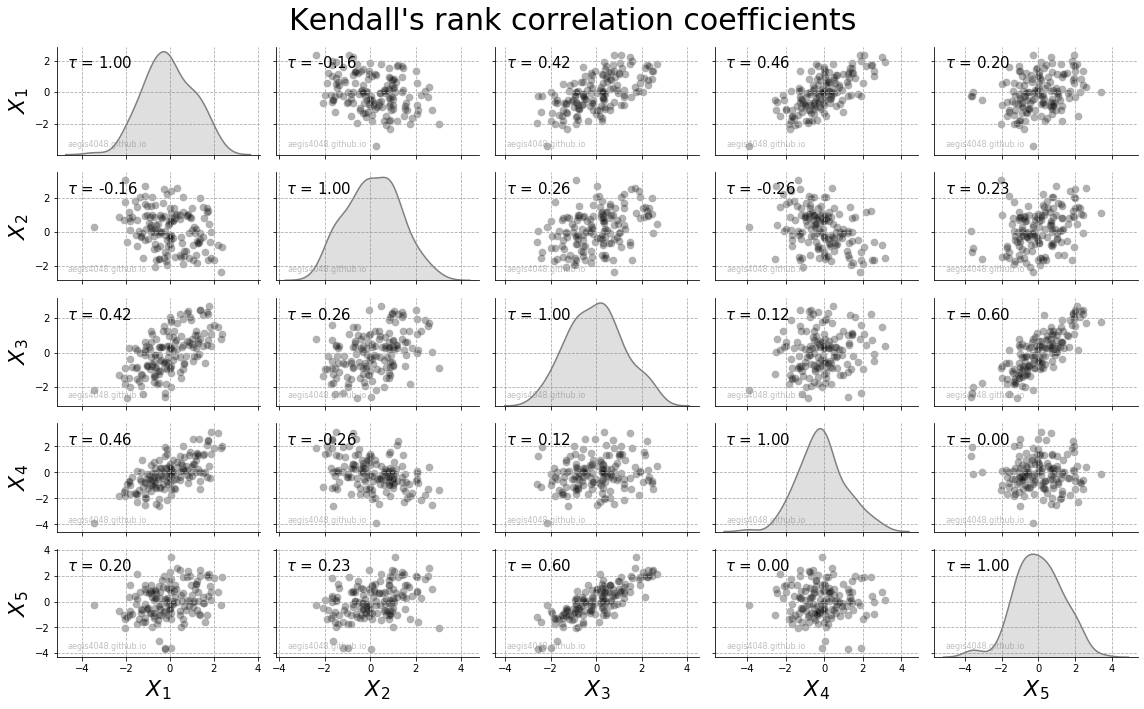

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('sample_data/collinear.csv')
corr = df.corr(method='kendall').values

g = sns.pairplot(df, diag_kind="kde",
                 plot_kws=dict(s=50, linewidth=1, alpha=0.3, color='k', edgecolor='grey'),
                 diag_kws=dict(shade=True, color='grey'),
                 height=2, aspect=1.6)

fontsize = 22
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if i == 0:
            g.axes[j,i].yaxis.set_label_text(df.columns[j], fontsize=fontsize)
        if j == len(df.columns) - 1:
            g.axes[j,i].xaxis.set_label_text(df.columns[i], fontsize=fontsize)
        
        g.axes[j, i].text(0.05, 0.8, r'$\tau$ = %.2f' % corr[j, i], fontsize=15, transform=g.axes[j, i].transAxes)
        g.axes[j, i].grid(True, linestyle='--', color='#acacac')
        g.axes[j, i].text(0.25, 0.1, 'aegis4048.github.io', fontsize=8, ha='center', va='center',
        transform=g.axes[j, i].transAxes, color='grey', alpha=0.5)

g.fig.suptitle('Kendall\'s rank correlation coefficients', fontsize=30)
g.fig.tight_layout(rect=[0, 0, 1, 0.94])

In [3]:
g.fig.savefig('multicollinearity_pairplot_kendall.png', dpi=400)

<div class="highlights red-theme" id="correlation-matrix-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme"><b>Do not use correlation matrix as a measure of multicollinearity!</b> Correlation matrix captures pairwise correlations. In the other words, it only captures one-to-one collinearity. It fails to capture one-to-many multicollinearity. A bunch of pairwise low to medium correlations is not a sufficient test for lack of multicollinearity. Use correlation matrix only to detect which features are related to which features. For the test of overall multicollinearity, use VIF instead, which I discuss in <i>Section 4.1: VIF</i> <a href="#VIF">above</a>.
    </div>
</div>



So although a high correlation coefficient would be sufficient to establish that collinearity might be a problem, a bunch of pairwise low to medium correlations is not a sufficient test for lack of collinearity. 

**Partial correlation coefficient**

Restricts the effect of confounding factors. 

**Semi-partial**

Assess linearity between x and y. Restricts the effect of other confounding factors for x, but not for y. 

--------------------------------------------------------------------------------


Covariance, semi-partial correlation, partial correlation, spearman-rank correlation, pearson's correlation,

Correlation matrix measures 

I see correlation matrix a means of elimination technique. You know that if something is essential based on feature ranking. Try removing multicollinearity by eliminating features that show high correlation to the 



https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_variable_ranking.ipynb

## 5.1. Elimination

**Using correlation matrix**

**Using feature ranking**

Recall that the measure of multicollinearty, VIF, is computed by regressing a predictor against other predictors. 

**Pythonic Tip:**

In [38]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels.formula.api as smf

In [48]:
df = df.iloc[:, 1:]

In [49]:
df_cor = df.corr()
pd.DataFrame(np.linalg.inv(df.corr().values), index = df_cor.index, columns=df_cor.columns)

,Por,Perm,AI,Brittle,TOC,VR,Prod
Por,16.176635,0.949103,-1.737039,6.897739,-0.963265,2.655457,-17.175719
Perm,0.949103,3.886711,-2.852903,1.072081,-1.333245,2.810110,-5.050239
AI,-1.737039,-2.852903,8.736127,0.781396,6.358676,-7.846188,5.175854
Brittle,6.897739,1.072081,0.781396,5.321840,2.147779,-0.686299,-8.865597
TOC,-0.963265,-1.333245,6.358676,2.147779,7.400963,-6.199942,0.936102
VR,2.655457,2.810110,-7.846188,-0.686299,-6.199942,8.462222,-5.914026
Prod,-17.175719,-5.050239,5.175854,-8.865597,0.936102,-5.914026,24.901696


In [40]:
exogs = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

data = df[exogs]

vif_dict, tolerance_dict = {}, {}
df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})
    vif_dict[exog] = vif

# create formula for each exogenous variable
for exog in exogs:
    not_exog = [i for i in exogs if i != exog]
    formula = f"{exog} ~ {' + '.join(not_exog)}"

    # extract r-squared from the fit
    r_squared = smf.ols(formula, data=data).fit().rsquared

    # calculate VIF
    vif = 1/(1 - r_squared)
    vif_dict[exog] = vif

    # calculate tolerance
    tolerance = 1 - r_squared
    tolerance_dict[exog] = tolerance

# return VIF DataFrame
df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

df_vif

,VIF,Tolerance
AI,7.660318,0.130543
Brittle,2.165476,0.461792
Perm,2.862487,0.349347
Por,4.329838,0.230956
TOC,7.365773,0.135763
VR,7.057671,0.141690


In [27]:
exogs = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

data = df[exogs]

vif_dict, tolerance_dict = {}, {}

# form input data for each exogenous variable
for exog in exogs:
    not_exog = [i for i in exogs if i != exog]
    X, y = data[not_exog], data[exog]

    # extract r-squared from the fit
    r_squared = LinearRegression().fit(X, y).score(X, y)

    # calculate VIF
    vif = 1/(1 - r_squared)
    vif_dict[exog] = vif

    # calculate tolerance
    tolerance = 1 - r_squared
    tolerance_dict[exog] = tolerance

# return VIF DataFrame
df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

df_vif

,VIF,Tolerance
AI,7.660318,0.130543
Brittle,2.165476,0.461792
Perm,2.862487,0.349347
Por,4.329838,0.230956
TOC,7.365773,0.135763
VR,7.057671,0.141690


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
import statsmodels.api as sm

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

X = df[features].values.reshape(-1, len(features))

vif = pd.DataFrame()
X = sm.add_constant(X)
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

In [53]:
vif

,Features,VIF
0,Por,161.797377
1,Brittle,4.329838
2,Perm,2.165476
3,TOC,2.862487
4,AI,7.365773
5,VR,7.660318


In [34]:
y = X[:, 0]
X_new = X[:, 1:]

In [35]:
X_new.shape

(200, 5)

In [36]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
model = ols.fit(X_new, y)
model.score(X_new, y)

0.7690444904327748

In [37]:
1 / (1 - model.score(X_new, y)**2)

2.447557580452999

In [66]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

df_features = df[features]

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np

In [79]:
df = pd.DataFrame(
    {'a': [1, 1, 2, 3, 4],
     'b': [2, 2, 3, 2, 1],
     'c': [4, 6, 7, 8, 9],
     'd': [4, 3, 4, 5, 4]}
)

In [80]:
X = add_constant(df)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const    136.875
a         22.950
b          3.000
c         12.950
d          3.000
dtype: float64

In [81]:
df_cor = df.corr()
temp = pd.DataFrame(np.linalg.inv(df_cor.values), index = df_cor.index, columns=df_cor.columns)
np.diag(temp)

array([22.95,  3.  , 12.95,  3.  ])

In [68]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

features = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']

df_features = df[features]

In [82]:
X = add_constant(df_features)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const      161.797377
Por          4.329838
Brittle      2.165476
Perm         2.862487
TOC          7.365773
AI           7.660318
VR           7.057671
dtype: float64

In [78]:
k_vars = exog.shape[1]
x_i = exog[:, exog_idx]
mask = np.arange(k_vars) != exog_idx
x_noti = exog[:, mask]
r_squared_i = OLS(x_i, x_noti).fit().rsquared
vif = 1. / (1. - r_squared_i)

AttributeError: 'str' object has no attribute 'shape'

In [84]:
import pandas as pd
import statsmodels.formula.api as smf

def get_vif(exogs, data):
    '''Return VIF (variance inflation factor) DataFrame

    Args:
    exogs (list): list of exogenous/independent variables
    data (DataFrame): the df storing all variables

    Returns:
    VIF and Tolerance DataFrame for each exogenous variable

    Notes:
    Assume we have a list of exogenous variable [X1, X2, X3, X4].
    To calculate the VIF and Tolerance for each variable, we regress
    each of them against other exogenous variables. For instance, the
    regression model for X3 is defined as:
                        X3 ~ X1 + X2 + X4
    And then we extract the R-squared from the model to calculate:
                    VIF = 1 / (1 - R-squared)
                    Tolerance = 1 - R-squared
    The cutoff to detect multicollinearity:
                    VIF > 10 or Tolerance < 0.1
    '''

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [96]:
get_vif(['a', 'b', 'c', 'd'], df)

,VIF,Tolerance
a,22.95,0.043573
b,3.00,0.333333
c,12.95,0.077220
d,3.00,0.333333


In [95]:
df = pd.DataFrame(
    {'a': [1, 1, 2, 3, 4],
     'b': [2, 2, 3, 2, 1],
     'c': [4, 6, 7, 8, 9],
     'd': [4, 3, 4, 5, 4]}
)

In [101]:
data = df

not_exog = ['b', 'c', 'd']
exog = 'a'
X, y = data[not_exog], data[exog]

# extract r-squared from the fit
r_squared = LinearRegression().fit(X, y).score(X, y)

# calculate VIF
vif = 1/(1 - r_squared)

vif

22.949999999999985


1. Introduction
    - Nfoi + Gfgi example, standard error is important (possibly estimating OOIP + OGIP after PCA treament?)
    - Note that this multicollinearity does not degrade the prediction power of a model
            
2. Key Takeaways
    - Multicollinearity occurs when (can be described by ...)
    - Multicollinearity makes the values of individual regression coefficients are unreliable
        * It can cause change in the signs as well as in the magnitudes from one sample to another sample. If you concluded that feature x1 has a positive impact on a response variable y because the regression coefficient of x1 is positive, this might be wrong. I show this here and here. 
    - Multicollinearity does not affect the prediction power on a response variable (bundle)
    - Use VIF to detect and remove collinear features (if VIF > 10, its problematic)
    - Sometimes multicollinearity can be safely ignored (https://statisticalhorizons.com/multicollinearity)
    - Multicollinearity among independent variables will result in less reliable statistical inferences.
    
3. Concept
    - Thought experiment
    
4. Causes
    - Generally occurs when features are highly correlated
    - Incorrect dummy variable encoding
    - Repetition of the same feature (different units)
    - A feature computed from other features is in the data set.
    
5. Effects    
    - (This makes interpretation unreliable)
    - Model Instability with sampling
        * Python simulation, 2D plot
    - Model instability with feature selection
        * Same screenshot used in previous post
    - Overestimated standard errors
        * 95% conf int Box plots for each regression coefficients, paired with sampling vs regression analysis
    - Notes: Value of regression coefficient is not feature importance
    - (Perhaps significance test)

6. Detection
    - Correlation matrix
    - VIF score
        * A Caution Regarding Rules of Thumb for Variance Inflation Factors
        * https://link.springer.com/article/10.1007/s11135-006-9018-6
    
7. Remedies
    - Removal (VIF score + correlation matrix) (If that features is necessary, tough luck)
    - Principle Component Regression
        * PCA is generally used when the aim is to retrieve a latent unmeasured variable or set of variables proxied by measured manifestation variables: for example, economic openness is not directly measured but there are indicators for it such as trade volume, trade tariffs, exchange policy, etc. So pca is implemented in order to assess a synthetic variable for the Economic openness. You will have to find a “meaning” for your principal components based on the coordinates of the original variables relative to each component
        * Warning: Interpretation of principle components. Do it only if you really understand what PCA does. 
    - Mean centering
        * Do not standardize, by Jim
        * Notes: STD dividing for non-normal distributions
        * https://statisticsbyjim.com/regression/standardize-variables-regression/
        
8. Excuses to ignore multicollinearity (or Pitfalls)

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm

In [122]:
features = ['a1', 'a2']
true_coefs = [2, 4]
true_intercept = 1
n = 100

In [182]:
correlation = 0

cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_low = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_low.append(model.coef_)
    
model_coefs_low = np.array(model_coefs_low)

In [184]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

features = ['a1', 'a2']

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,3.893106
1,a2,3.893106


In [185]:
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     851.7
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.97e-62
Time:                        21:12:33   Log-Likelihood:                -140.88
No. Observations:                 100   AIC:                             287.8
Df Residuals:                      97   BIC:                             295.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3984      0.488      2.868      0.0

In [168]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

features = ['a1', 'a2']

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,18.710929
1,a2,18.710929


In [169]:
correlation = 0.99

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_high = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_high.append(model.coef_)
    
model_coefs_high = np.array(model_coefs_high)

In [170]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,28.032218
1,a2,28.032218


In [171]:
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1207.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.96e-69
Time:                        21:11:33   Log-Likelihood:                -143.14
No. Observations:                 100   AIC:                             292.3
Df Residuals:                      97   BIC:                             300.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9978      1.587      1.259      0.2

Text(0, 0.5, 'a2')

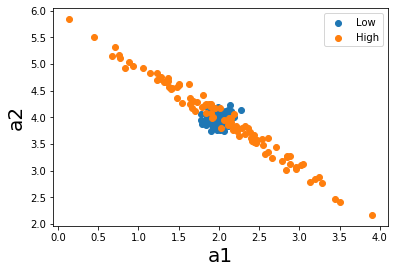

In [172]:
fig, ax = plt.subplots()

ax.scatter(model_coefs_low[:, 0], model_coefs_low[:, 1], label='Low')
ax.scatter(model_coefs_high[:, 0], model_coefs_high[:, 1], label='High')
ax.legend()
ax.set_xlabel('a1', fontsize=20)
ax.set_ylabel('a2', fontsize=20)

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Original

In [92]:
features = ['a1', 'a2']
true_coefs = [10, 15]
true_intercept = 2
n = 100

In [121]:
correlation = 0.99

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_orig = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_orig.append(model.coef_)
    
model_coefs_orig = np.array(model_coefs_orig)

In [122]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,19.583652
1,a2,19.583652


In [123]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.036e+04
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          2.17e-136
Time:                        21:58:41   Log-Likelihood:                -139.20
No. Observations:                 100   AIC:                             284.4
Df Residuals:                      97   BIC:                             292.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9605      1.506      1.966      0.0

In [124]:
print('a1 = [%.2f' % np.percentile(model_coefs_orig[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_orig[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 1], 97.5))

a1 = [8.86  11.52]
a2 = [13.52  16.08]


# PCA

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [126]:
features = ['a1', 'a2']
true_coefs = [10, 15]
true_intercept = 2
n = 100

In [127]:
correlation = 0.95

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_pca = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(X)

    # PCA
    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_pca.append(model.coef_)
    
model_coefs_pca = np.array(model_coefs_pca)

In [128]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,1.0
1,a2,1.0


In [129]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     8396.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          2.09e-109
Time:                        21:58:47   Log-Likelihood:                -150.29
No. Observations:                 100   AIC:                             306.6
Df Residuals:                      97   BIC:                             314.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0979      0.110     18.999      0.0

In [130]:
print('a1 = [%.2f' % np.percentile(model_coefs_pca[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_pca[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 1], 97.5))

a1 = [9.84  10.13]
a2 = [14.01  15.98]


# Centering

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [132]:
features = ['a1', 'a2']
true_coefs = [10, 15]
true_intercept = 2
n = 100

In [133]:
correlation = 0.95

# construct 2D positive-semidefinite covariance matrix
cov = [[1, correlation], 
       [correlation, 1]]

model_coefs_center = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4], cov=cov, size=n)
    
    scalar = StandardScaler(with_std=False)
    X = scalar.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=1, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_center.append(model.coef_)
    
model_coefs_center = np.array(model_coefs_center)

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,11.76716
1,a2,11.76716


In [135]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.898e+04
Date:                Fri, 29 Nov 2019   Prob (F-statistic):          1.20e-141
Time:                        21:59:00   Log-Likelihood:                -134.28
No. Observations:                 100   AIC:                             274.6
Df Residuals:                      97   BIC:                             282.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1242      0.094     22.575      0.0

In [137]:
print('a1 = [%.2f' % np.percentile(model_coefs_center[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_center[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 1], 97.5))

a1 = [9.37  10.76]
a2 = [14.29  15.65]


Text(0, 0.5, 'a2')

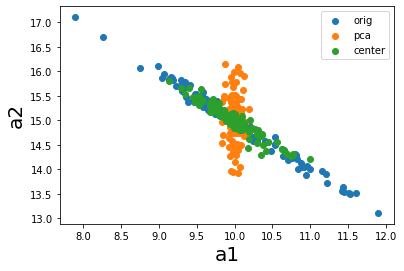

In [136]:
fig, ax = plt.subplots()

ax.scatter(model_coefs_orig[:, 0], model_coefs_orig[:, 1], label='orig')
ax.scatter(model_coefs_pca[:, 0], model_coefs_pca[:, 1], label='pca')
ax.scatter(model_coefs_center[:, 0], model_coefs_center[:, 1], label='center')
ax.legend()
ax.set_xlabel('a1', fontsize=20)
ax.set_ylabel('a2', fontsize=20)

# 3 features

# original

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [152]:
features = ['a1', 'a2', 'a3']
true_coefs = [2, 4, 10]
true_intercept = 2
n = 100

In [159]:
# construct 2D positive-semidefinite covariance matrix
cov = [[1, 0.95, 0.93], 
       [0.95, 1, 0.95],
       [0.93, 0.95, 1]]

model_coefs_orig = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4, 10], cov=cov, size=n)

    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=2, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_orig.append(model.coef_)
    
model_coefs_orig = np.array(model_coefs_orig)

In [160]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,41.566893
1,a2,246.401621
2,a3,113.336348


In [161]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1298.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.54e-77
Time:                        22:03:37   Log-Likelihood:                -214.78
No. Observations:                 100   AIC:                             437.6
Df Residuals:                      96   BIC:                             448.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2692      4.590      0.712      0.4

In [162]:
print('a1 = [%.2f' % np.percentile(model_coefs_orig[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_orig[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_orig[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 2], 97.5))

a1 = [0.80  3.09]
a2 = [2.95  5.45]
a3 = [8.42  11.17]


# PCA

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [171]:
features = ['a1', 'a2', 'a3']
true_coefs = [2, 4, 10]
true_intercept = 2
n = 100

In [174]:
# construct 2D positive-semidefinite covariance matrix
cov = [[1, 0.95, 0.93], 
       [0.95, 1, 0.95],
       [0.93, 0.95, 1]]

model_coefs_pca = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4, 10], cov=cov, size=n)

    scalar = StandardScaler()
    X = scalar.fit_transform(X)

    # PCA
    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=2, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_pca.append(model.coef_)
    
model_coefs_pca = np.array(model_coefs_pca)

In [175]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,1.0
1,a2,1.0
2,a3,1.0


In [176]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     172.9
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.43e-38
Time:                        22:07:19   Log-Likelihood:                -206.91
No. Observations:                 100   AIC:                             421.8
Df Residuals:                      96   BIC:                             432.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6930      0.196      8.658      0.0

In [177]:
print('a1 = [%.2f' % np.percentile(model_coefs_pca[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_pca[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_pca[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 2], 97.5))

a1 = [1.82  2.24]
a2 = [2.64  5.85]
a3 = [8.33  11.93]


# Centering

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [143]:
features = ['a1', 'a2', 'a3']
true_coefs = [2, 4, 10]
true_intercept = 2
n = 100

In [164]:
# construct 2D positive-semidefinite covariance matrix
cov = [[1, 0.95, 0.93], 
       [0.95, 1, 0.95],
       [0.93, 0.95, 1]]

model_coefs_center = []
for i in range(100):
    
    # random generation of 2D collinear gaussian multivariate distribution with covariance matrix
    X = np.random.multivariate_normal(mean=[2, 4, 10], cov=cov, size=n)
    
    scalar = StandardScaler(with_std=False)
    X = scalar.fit_transform(X)
    
    # generate gaussian white noise
    gaussian_noise = np.random.normal(loc=0, scale=2, size=n)
    
    # make the outcome
    y = true_intercept + true_coefs[0] * X[:, 0] + true_coefs[1] * X[:, 1] + true_coefs[2] * X[:, 2] + gaussian_noise
    
    # fit linear model
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    model_coefs_center.append(model.coef_)
    
model_coefs_center = np.array(model_coefs_center)

In [145]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

vif

,Features,VIF
0,a1,11.866335
1,a2,17.993888
2,a3,11.526422


In [146]:
X_st = sm.add_constant(X)
sm_model = sm.OLS(y, X_st).fit()
predictions = sm_model.predict(X_st)
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2215.
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.82e-88
Time:                        22:00:06   Log-Likelihood:                -203.14
No. Observations:                 100   AIC:                             414.3
Df Residuals:                      96   BIC:                             424.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2459      0.188     11.927      0.0

In [168]:
print('a1 = [%.2f' % np.percentile(model_coefs_center[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_center[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_center[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 2], 97.5))

a1 = [0.76  3.29]
a2 = [2.49  5.35]
a3 = [8.65  11.24]


In [180]:
print('Original')
print('a1 = [%.2f' % np.percentile(model_coefs_orig[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_orig[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_orig[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_orig[:, 2], 97.5))
print('\nPCA')
print('a1 = [%.2f' % np.percentile(model_coefs_pca[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_pca[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_pca[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_pca[:, 2], 97.5))
print('\nCenter')
print('a1 = [%.2f' % np.percentile(model_coefs_center[:, 0], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 0], 97.5))
print('a2 = [%.2f' % np.percentile(model_coefs_center[:, 1], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 1], 97.5))
print('a3 = [%.2f' % np.percentile(model_coefs_center[:, 2], 2.5), ' %.2f]' % np.percentile(model_coefs_center[:, 2], 97.5))

Original
a1 = [0.80  3.09]
a2 = [2.95  5.45]
a3 = [8.42  11.17]

PCA
a1 = [1.82  2.24]
a2 = [2.64  5.85]
a3 = [8.33  11.93]

Center
a1 = [0.76  3.29]
a2 = [2.49  5.35]
a3 = [8.65  11.24]


In [ ]:
true_coefs = [2, 4, 10]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2252.
Date:                Wed, 27 Nov 2019   Prob (F-statistic):           9.23e-31
Time:                        19:04:04   Log-Likelihood:                -362.09
No. Observations:                  29   AIC:                             728.2
Df Residuals:                      27   BIC:                             730.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.023e+07   8.73e+06     10.340      0.0

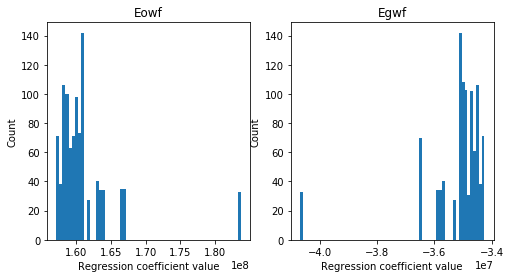

In [20]:
file = 'sample_data/ooip_ogip.csv'
df = pd.read_csv(file)

features = ['Eowf', 'Egwf']
target = 'F'

# preprocessing required by sklearn
X = df[features].values.reshape(-1, len(features))
y = df[target].values

# Compute VIF
vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

# statsmodel
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

print('\n\n\n\n')
print(vif)

coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.95)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

<class 'numpy.ndarray'>
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.992
Date:                Fri, 29 Nov 2019   Prob (F-statistic):             0.0671
Time:                        21:09:39   Log-Likelihood:                -433.47
No. Observations:                  29   AIC:                             870.9
Df Residuals:                      27   BIC:                             873.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.412e+05   1.02

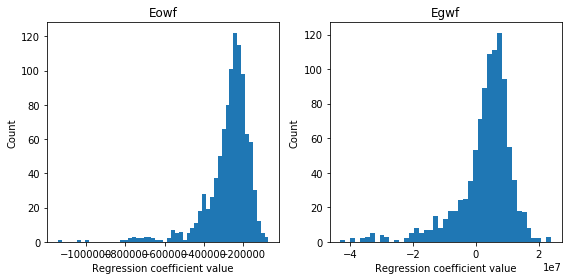

In [163]:
file = 'sample_data/ooip_ogip.csv'
df = pd.read_csv(file)

features = ['Eowf', 'Egwf']
target = 'F'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

print(type(X))

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    
    # randomly sample 70% of the original data. This is essentially bootstrapping
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression(fit_intercept=False)
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

In [17]:
sm_model.params

array([ 3844830.39400844, -3503719.21148126])

In [18]:
pca_inverse = pca.inverse_transform(sm_model.params)
pca_inverse

array([-5196209.2579275 ,  -241202.03030353])

In [19]:
pca_inverse = pca.inverse_transform(sm_model.params)

scalar.inverse_transform(pca_inverse)

array([-124291.81061746,  -24081.35939605])

In [6]:
coefs

array([[  -251725.52996658,   6784667.67113444],
       [  -659868.94590499, -11829722.22955466],
       [  -191775.09498549,  -1408872.44269721],
       ...,
       [  -298643.41037758,   3678384.98523384],
       [  -264200.68853622,   2165056.06443315],
       [  -201849.14634761,   4924510.92333155]])

In [6]:
file = 'sample_data/ooip_ogip.csv'
df = pd.read_csv(file)

features = ['Eowf', 'Egwf']
target = 'F'

In [9]:
X = df[features].values.reshape(-1, len(features))
y = df[target].values

ols = linear_model.LinearRegression(fit_intercept=False)
model = ols.fit(X, y)

print(model.score(X, y))
print(model.coef_)

0.9734009040213185
[ 89137384.70067914 -18363222.42705864]


In [10]:
# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     798.1
Date:                Wed, 27 Nov 2019   Prob (F-statistic):           1.14e-28
Time:                        17:31:02   Log-Likelihood:                -442.12
No. Observations:                  36   AIC:                             890.2
Df Residuals:                      33   BIC:                             895.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.183e+05   3.68e+04      3.215      0.0

multicollinearity is a problem with Mahalanobis distance. 

https://python-data-science.readthedocs.io/en/latest/unsupervised.html
While powerful, its use of correlation can be detrimantal when there is multicollinearity (strong correlations among features).

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     768.8
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          8.13e-132
Time:                        04:57:10   Log-Likelihood:                -1341.7
No. Observations:                 200   AIC:                             2697.
Df Residuals:                     193   BIC:                             2721.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1230.2620    181.565     -6.776      0.0

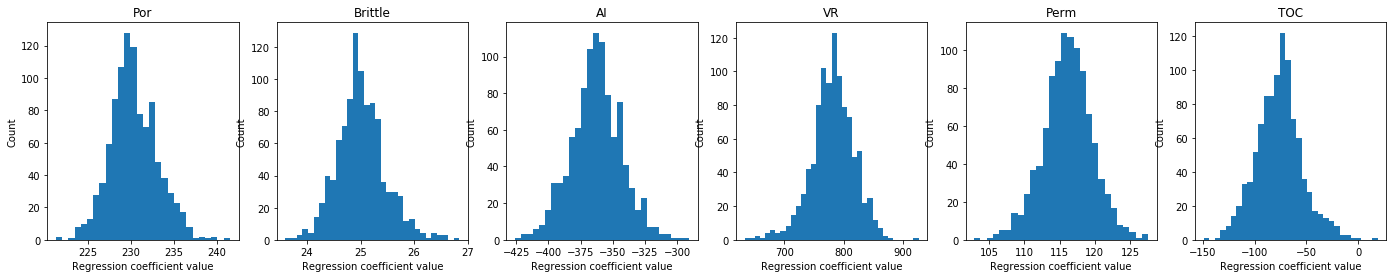

In [23]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

# preprocessing required by sklearn
X = df[features].values.reshape(-1, len(features))
y = df[target].values

# Compute VIF
vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

print('\n\n\n\n')
print(vif)

coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.95)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     768.8
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          8.13e-132
Time:                        04:57:23   Log-Likelihood:                -1341.7
No. Observations:                 200   AIC:                             2697.
Df Residuals:                     193   BIC:                             2721.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1230.2620    181.565     -6.776      0.0

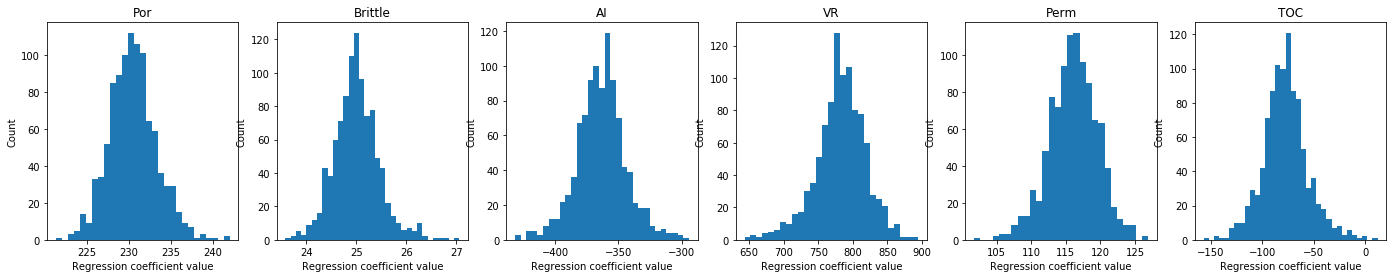

In [24]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

# preprocessing required by sklearn
X = df[features].values.reshape(-1, len(features))
y = df[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

# Compute VIF
vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print('\n\n\n\n')
print(vif)

coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.95)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Raw

In [3]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,7.363348
1,Brittle,7.363348


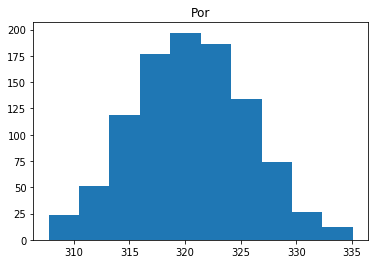

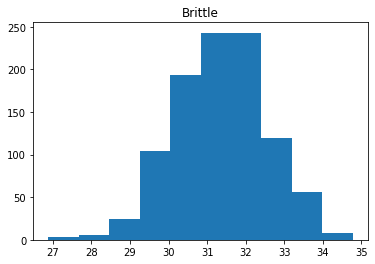

In [3]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

In [11]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,225.857649
1,Brittle,39.077458
2,AI,208.845031
3,VR,362.619204
4,Perm,27.982176
5,TOC,35.538260
6,Prod,401.944335


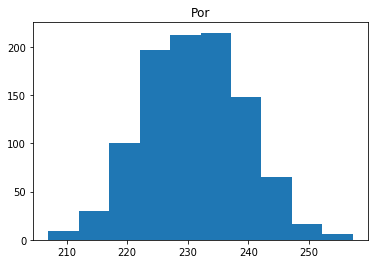

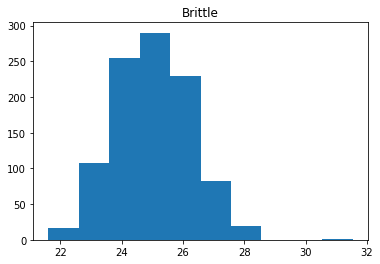

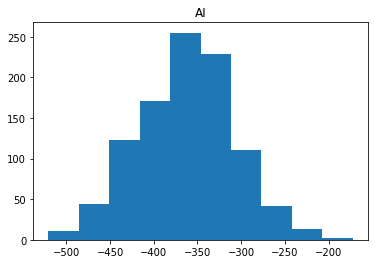

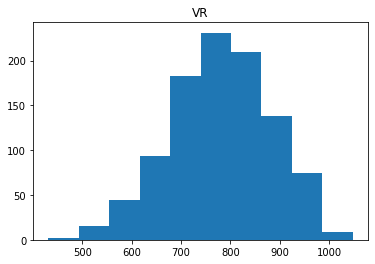

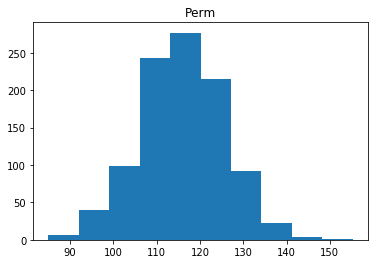

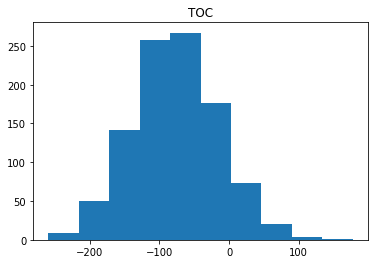

In [5]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

# Centered

In [55]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle']
target = 'Prod'

scalar = StandardScaler(with_std=False)
X = scalar.fit_transform(df[features])

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.05017
1,Brittle,1.05017


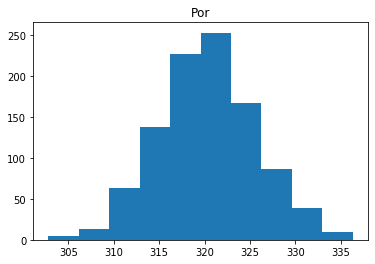

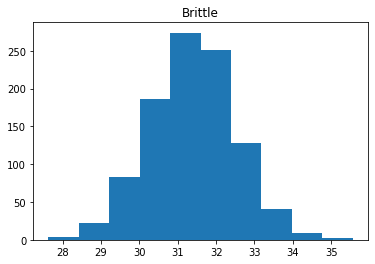

In [56]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

In [57]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

scalar = StandardScaler(with_std=False)
X = scalar.fit_transform(df[features])

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,4.329838
1,Brittle,2.165476
2,AI,7.660318
3,VR,7.057671
4,Perm,2.862487
5,TOC,7.365773


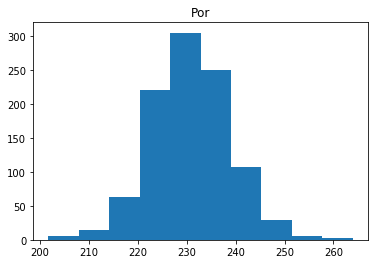

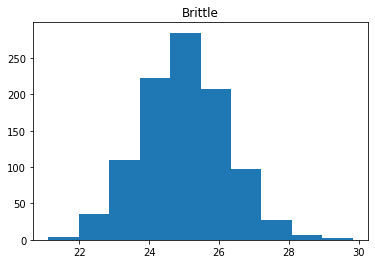

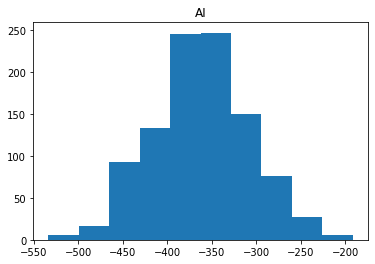

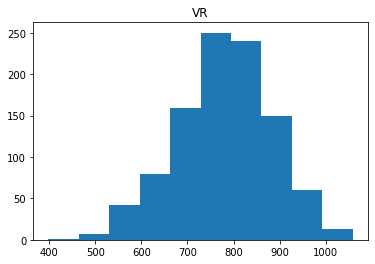

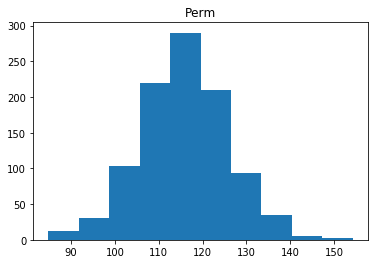

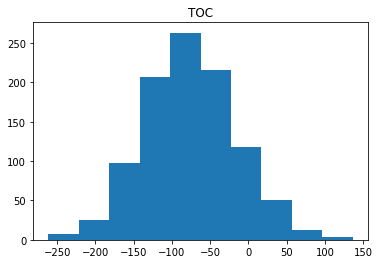

In [58]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i])
    ax.set_title(feature)

# PCA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     768.8
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          8.13e-132
Time:                        04:57:36   Log-Likelihood:                -1341.7
No. Observations:                 200   AIC:                             2697.
Df Residuals:                     193   BIC:                             2721.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4311.2199     14.274    302.032      0.0

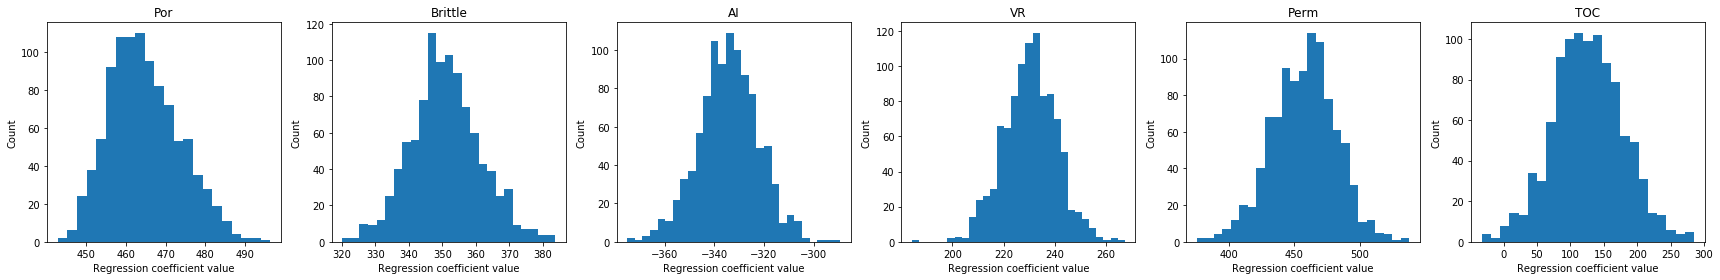

In [25]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    
    # randomly sample 70% of the original data. This is essentially bootstrapping
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     766.9
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          4.69e-118
Time:                        04:57:42   Log-Likelihood:                -1381.5
No. Observations:                 200   AIC:                             2773.
Df Residuals:                     195   BIC:                             2790.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4311.2199     17.324    248.857      0.0

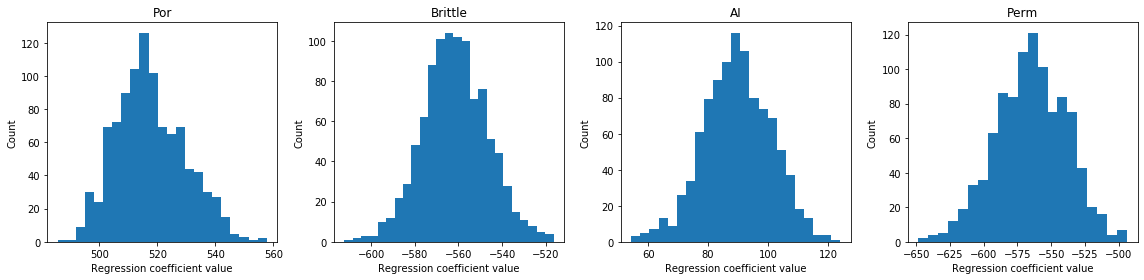

In [26]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'Perm']
target = 'Prod'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1373.
Date:                Wed, 27 Nov 2019   Prob (F-statistic):          2.14e-116
Time:                        04:57:46   Log-Likelihood:                -1392.8
No. Observations:                 200   AIC:                             2792.
Df Residuals:                     197   BIC:                             2802.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4311.2199     18.241    236.347      0.0

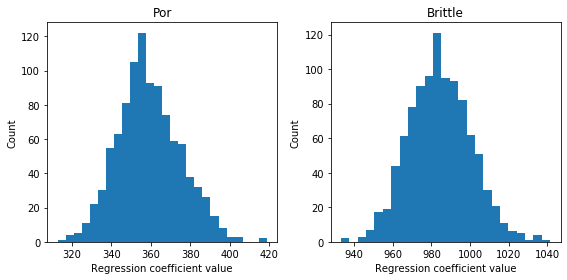

In [27]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle']
target = 'Prod'

# Standardization
scalar = StandardScaler()
X = scalar.fit_transform(df[features])

# PCA
pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

# Reconstruct df with transformed features
df_trans = pd.DataFrame(X)
df_trans[target] = df[target]
df_trans.columns = features + [target]

# preprocessing required by sklearn
X = df_trans[features].values.reshape(-1, len(features))
y = df_trans[target].values

# statsmodel
X_st = sm.add_constant(X)
model = sm.OLS(y, X_st).fit()
predictions = model.predict(X_st)
print(model.summary())

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])

print(vif)

coefs = []
for i in range(1000):
    df_temp = df_trans.sample(frac=0.7)

    X = df_temp[features].values.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')
    
fig.tight_layout()

In [4]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'Perm', 'AI']
target = 'Prod'

scalar = StandardScaler()
X = scalar.fit_transform(df[features])

pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.0
1,Brittle,1.0
2,Perm,1.0
3,AI,1.0


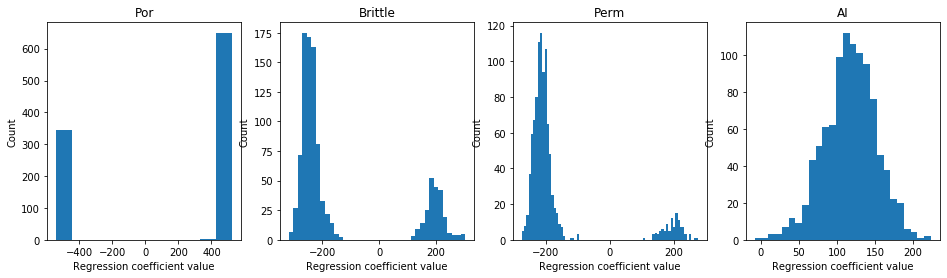

In [5]:
coefs = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(df_temp.values)

    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)

    X = X.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
coefs = np.array(coefs)

fig, axes = plt.subplots(1, len(features), figsize=(4 * len(features), 4))

for i, feature in enumerate(features):
    axes[i].hist(coefs[:, i], bins='auto')
    axes[i].set_title(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Regression coefficient value')

In [6]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

scalar = StandardScaler()
X = scalar.fit_transform(df.values)

pca = PCA(n_components=len(features))
X = pca.fit_transform(X)

X = X.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.0
1,Brittle,1.0
2,AI,1.0
3,VR,1.0
4,Perm,1.0
5,TOC,1.0


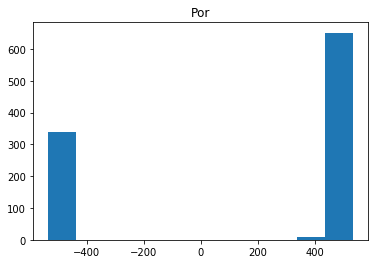

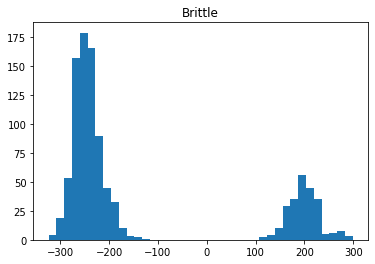

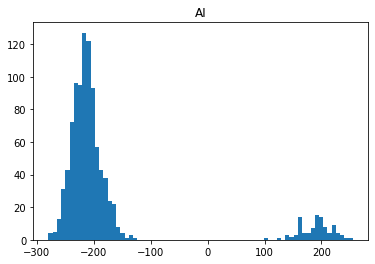

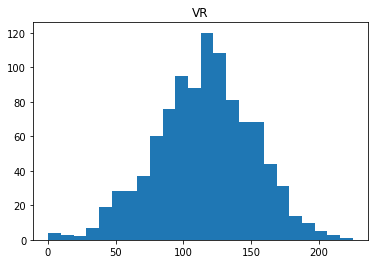

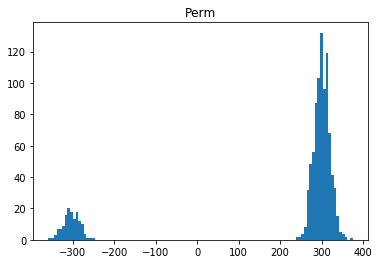

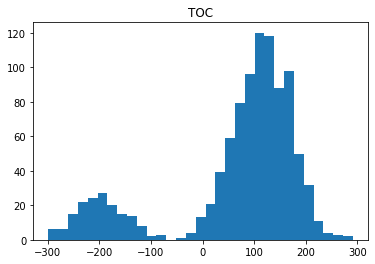

In [7]:
coefs = []
r = []
for i in range(1000):
    df_temp = df.sample(frac=0.7)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(df_temp.values)

    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)

    X = X.reshape(-1, len(features))
    y = df_temp[target].values
    
    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    
    coefs.append(model.coef_)
    
    r.append(model.score(X, y))
    
coefs = np.array(coefs)

for i, feature in enumerate(features):
    fig, ax = plt.subplots()
    ax.hist(coefs[:, i], bins='auto')
    ax.set_title(feature)

In [9]:
coefs[:, -1]

array([-214.5982385 ,  123.74342539,   70.77110659,   56.87212411,
         56.53388293,  164.46445716,  131.33881182,   55.34281759,
        166.52876831,   58.30200155,  129.30784068,  110.76253426,
         -8.5205867 ,   75.96285387,  162.9913495 ,  134.23211329,
         86.28961524,  258.79667236,   41.25975719,  174.58824505,
        165.76815614,  192.83252518,  162.09912498,  181.0609212 ,
        133.6041303 ,   91.74225786,  162.3437963 ,  134.25806308,
        167.63417848, -243.73087435,  151.58283645, -182.96664201,
        -73.94919992, -143.68758187,  211.68019925,  141.48369222,
       -252.84766516,  238.54549752,  170.26866752,  103.30889493,
       -216.32541621,   97.50450336,   62.22314081,  122.47958225,
       -182.42362655,  120.40220087,   82.49752192,  105.8806393 ,
         78.66881573,   88.34884903,  126.40364343,    7.58734101,
        118.10461083,  141.16959885, -241.62083627,  -12.79692893,
        105.66806216,   67.33793977, -182.7729212 , -185.66768

In [59]:
    df_temp = df.sample(frac=0.7)
    
    scalar = StandardScaler()
    X = scalar.fit_transform(df_temp.values)

    pca = PCA(n_components=len(features))
    X = pca.fit_transform(X)

In [61]:
pca.explained_variance_

array([3.36520575, 1.6300189 , 1.05796411, 0.75059836, 0.17773085,
       0.04717506])

In [62]:
features

['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']

In [70]:
import statsmodels.api as sm

res = sm.OLS(y, X).fit()

ImportError: cannot import name 'factorial'

In [28]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

########################################################################################

features = ['Por', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

pca = PCA(n_components=len(features))
X_new = pca.fit_transform(X)

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X_new, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.0
1,AI,1.0
2,VR,1.0
3,Perm,1.0
4,TOC,1.0


In [29]:
ols = linear_model.LinearRegression()
model = ols.fit(X_new, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', model.coef_)
print('R-squared               :  %.2f' % model.score(X_new, y))
print('Y-intercept             :  %.2f' % model.intercept_)
print('')

Features                :  ['Por', 'AI', 'VR', 'Perm', 'TOC']
Regression Coefficients :  [  260.59912732   -18.97712619    90.43637731  -404.33137156
 -2682.99310784]
R-squared               :  0.90
Y-intercept             :  4311.22



In [18]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file).iloc[:, 1:]

scalar = StandardScaler(with_std=False)
X_new = scalar.fit_transform(df.values)

df = pd.DataFrame(X_new, columns=df.columns)

########################################################################################

features = ['Por', 'Brittle', 'AI']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,1.313968
1,Brittle,1.051171
2,AI,1.271905


In [19]:
ols = linear_model.LinearRegression()
model = ols.fit(X, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', model.coef_)
print('R-squared               :  %.2f' % model.score(X, y))
print('Y-intercept             :  %.2f' % model.intercept_)
print('')

Features                :  ['Por', 'Brittle', 'AI']
Regression Coefficients :  [319.43449102  31.38905371 -11.04275682]
R-squared               :  0.93
Y-intercept             :  -0.00



In [37]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

########################################################################################

features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

vif = pd.DataFrame()
vif['Features'] = features
vif['VIF'] = np.array([variance_inflation_factor(X, i) for i in range(len(features))])
vif

,Features,VIF
0,Por,62.645242
1,Brittle,19.370696
2,AI,122.734765
3,VR,259.597778
4,Perm,16.887354
5,TOC,33.668133


In [25]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

file = '500_Person_Gender_Height_Weight_Index.csv'
df = pd.read_csv(file)[['Height', 'Weight', 'Index']]

vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = np.array([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])

In [26]:
vif

,Features,VIF
0,Height,11.213321
1,Weight,37.566315
2,Index,20.881544


In [64]:
features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']

In [68]:
features = ['Por', 'Brittle', 'AI', 'VR', 'Perm', 'TOC']

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)[features]

vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = np.array([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])

In [69]:
vif

,Features,VIF
0,Por,42.751102
1,Brittle,8.576566
2,Perm,15.590663
3,TOC,10.075020


In [59]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

########################################################################################

features = ['Por', 'Brittle']
target = 'Prod'

X = df[features].values.reshape(-1, len(features))
y = df[target].values

ols = linear_model.LinearRegression()
model = ols.fit(X, y)

print('Features                :  %s' % features)
print('Regression Coefficients : ', [round(item, 2) for item in model.coef_])
print('R-squared               :  %.2f' % model.score(X, y))
print('Y-intercept             :  %.2f' % model.intercept_)
print('')

Features                :  ['Por', 'Brittle']
Regression Coefficients :  [320.39, 31.38]
R-squared               :  0.93
Y-intercept             :  -2003.01



In [62]:
file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)
df = df.iloc[:, 1:-1]

vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = np.array([variance_inflation_factor(df.values, i) for i in range(df.shape[1])])
vif

,Features,VIF
0,Por,62.645242
1,Perm,16.887354
2,AI,122.734765
3,Brittle,19.370696
4,TOC,33.668133
5,VR,259.597778


Multicollinearity can affect any regression model with more than one predictor. It occurs when two or more predictor variables overlap so much in what they measure that their effects are indistinguishable.

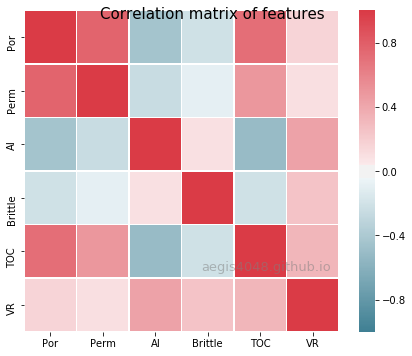

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

df = df.iloc[:, 1:-1]

corr = df.corr(method='spearman')

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=10)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=15)
ax.text(0.77, 0.2, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)

fig.tight_layout()